### **Contexto**

Identificada pela primeira vez em Dezembro de 2019, na China, a COVID-19 é uma doença causada pelo coronavirus que pegou o mundo inteiro de surpresa. Desde o começo da pandemia foram discutidas formas de achatar a distribuição de novos casos, para que os sistemas de saúde pudessem se preparar e impedir um possível colapso (falta de leitos, recursos humanos e EPIs para atender todos os pacientes). 
<br>
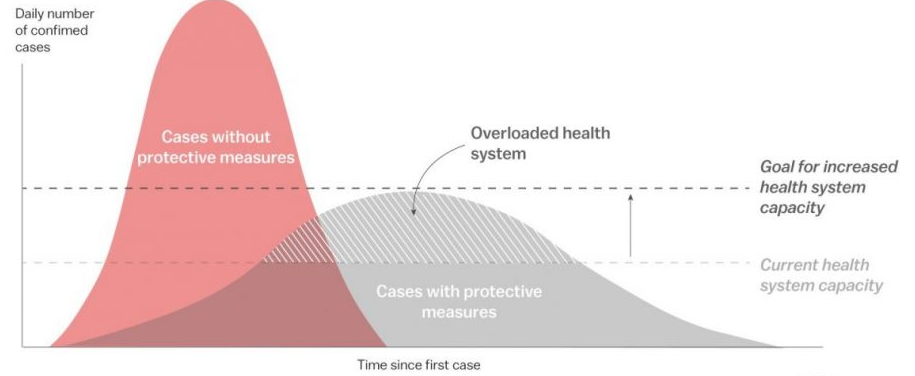
<br>

Infelizmente, o sistema de saúde brasileiro [colapsou em diversos estados](https://g1.globo.com/jornal-nacional/noticia/2021/01/11/sistema-de-saude-de-roraima-entra-em-colapso-por-causa-do-coronavirus.ghtml) mais de uma vez e, novamente, o país bate recordes no número de mortes e novos casos diários, um ano após o [primeiro caso de COVID-19 no Brasil](https://saude.abril.com.br/medicina/coronavirus-primeiro-caso-brasil/).



### Objetivo

Esse notebook tem como objetivo resolver a **Task 01** desenvolvida pelos autores do dataset (Felipe Oliveira et. al) utilizando os dados aqui disponibilizados.  
<br>

>Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.

### Metodologia

**Preparação dos Dados**: 
* Value imputation usando FFill e BFill;
* Retirada de colunas com alta correlação;
* Feature engineering leve (one-hot-encoding);
* Retirada das linhas contendo informações sobre janelas posteriores à entrada.

**Separação dos dados**: 75/25 estratificado.

**Definição do Modelo**: Foi utilizado LogisticRegression como baseline e K-Fold para definição do melhor modelo.

**Modelo Final**: RandomForest.

**Métricas de Avaliação, em ordem de importância**: Sensibilidade(recall), ROC(auc), especificidade e F1-score. 

**Hiperparametrização**: Uso de GridSearchCV em conjunto com inputs manuais.

### Resultados


Melhor **Score Geral**:

**ROC (AUC)**:             	     0.851582 	
**Sensibilidade**: 	 0.829268 	
**Especificidade**:     	     0.851063 	
**F1-score**:       	     0.829268 	
**Precisão**:       	     0.829268 	
**Acurácia**:        	     0.840909 


**Mediana de 50 iterações** do modelo acima, utilizando **random_state variável**:

| RF c/ GS Tunning - df_modelo_mediana_corte |  MEDIANA SCORES |   STD   |
|:--------------------------------------------------------:|:-------:|:-------:|
|                         ROC (AUC)                        | 0.79424 | 0.03438 |
|                  Sensibilidade - Recall                  | 0.70732 | 0.07316 |
|                      Especificidade                      | 0.74464 | 0.04241 |
|                         F1-score                         | 0.70737 | 0.04166 |
|                         Precisão                         | 0.70711 | 0.03999 |
|                         Acurácia                         | 0.72727 | 0.00321 |



### Import dos Módulos Utilizados e Input do Dataset

In [ ]:
!pip install openpyxl
!pip install shap
!pip install eli5
!pip install pdpbox

In [ ]:
# NumPy, Pandas & Visualização de Dados
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Scikit-Learn Metrics, Split and Validation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, recall_score, plot_confusion_matrix, f1_score, precision_score, accuracy_score, roc_curve, auc

# Scikit-Learn & XGBoost Algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# XAI
import shap
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots


plt.style.use('seaborn-colorblind')

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
path = "https://github.com/alura-cursos/covid-19-clinical-2/raw/main/Kaggle_Sirio_Libanes_ICU_Prediction%20(3).xlsx"

raw_df = pd.read_excel(path)
raw_df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

### Funções Helpers

In [ ]:
def colunas_correlacionadas(dataset, threshold = 0.95):
    
  '''   
  Retorna um dataframe com 3 colunas, sendo 
  duas delas o nome de colunas do dataframe de entrada e a 
  terceira o nível de correlação entre elas. Só serão retornadas
  colunas com correlação pearson com o valor mínimo definido no threshold
  
  Crédito: Matt Harrison @Machine Learning Pocket Reference
  '''

  df = dataset[dataset.describe().columns]  
  return (
      df.corr().pipe(lambda df1: pd.DataFrame(np.tril(df1,k=-1),
                                              columns = df.columns,
                                              index = df.columns,
                                              )
      )
      .stack()
      .rename("pearson")
      .pipe(
          lambda s: s[s.abs() >threshold].reset_index()
      )
      .query("level_0 not in level_1")
    )

In [ ]:
def makebio_df(df_in):
    
    '''
    Retorna um dataframe com as features consideradas pelos autores
    do dataset como biologicamente importantes
    '''
    
    df = df_in.copy()

    df["BLOODPRESSURE_ARTERIAL_MEAN"] = (df.loc[:,'BLOODPRESSURE_SISTOLIC_MEAN'] + 2*df.loc[:,'BLOODPRESSURE_DIASTOLIC_MEAN'])/3
 
    df["NEUTROPHILES/LINFOCITOS"] = df.loc[:,'NEUTROPHILES_MEAN']/df.loc[:,'LINFOCITOS_MEAN']

    df["GASO"] = df.groupby("PATIENT_VISIT_IDENTIFIER").P02_ARTERIAL_MEAN.apply(lambda x: x.fillna(method='ffill'))
    df["GASO"] = (~df.loc[:,"GASO"].isna()).astype(int)

    return df[["ICU_ANYTIME",
               "AGE_ABOVE65", 
               "GENDER", 
               "BLOODPRESSURE_ARTERIAL_MEAN", 
               "RESPIRATORY_RATE_MAX", 
               "HTN",
               'P02_ARTERIAL_MEAN',
               'DISEASE GROUPING 1',
               'DISEASE GROUPING 2',
               'DISEASE GROUPING 3',
               'DISEASE GROUPING 4',
               'DISEASE GROUPING 5',
               'DISEASE GROUPING 6',
               "GASO",
               "OXYGEN_SATURATION_MIN",
               "HEART_RATE_MAX",
               "PCR_MEAN",
               "CREATININ_MEAN"]]



In [ ]:
def avaliacao(model, X_test, y_test, X_train = None, y_train = None, train_aval = False, plot = False, cria_df = False):
    
    '''
    Calcula algumas medidas de score - Acurácia, Precisão, Recall e ROC(AUC).
    Se plot for definido como True, plota esses scores e uma matriz de 
    confusão para avaliação do modelo. Se cria_df for definido como True, retorna
    um dataframe com os resultados (para a função exec_modelagem)
    '''
    if train_aval:
        # TRAIN SCORES

        tn, fp, fn, tp = confusion_matrix(y_train, model.predict(X_train)).ravel()

        # Calcula os scores
        roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
        recall = recall_score(y_train, model.predict(X_train))
        especificidade = tn/(tn+fn)
        f_score = f1_score(y_train, model.predict(X_train))
        precisao = precision_score(y_train, model.predict(X_train))
        acuracia = accuracy_score(y_train, model.predict(X_train))

        # Printa os scores
        if plot:
            print("TRAIN SET SCORES")
            print(f"ROC (AUC): {roc_auc}")
            print(f"Sensibilidade - Recall: {recall}")
            print(f"Especificidade: {especificidade}")
            print(f"F1-score: {f_score}")
            print(f"Precisão: {precisao}")
            print(f"Acurácia: {acuracia}")
            print("\n")
            print("================================")
    
    
    # TEST SCORES
    
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    # Calcula os scores
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    recall = recall_score(y_test, model.predict(X_test))
    especificidade = tn/(tn+fn)
    f_score = f1_score(y_test, model.predict(X_test))
    precisao = precision_score(y_test, model.predict(X_test))
    acuracia = accuracy_score(y_test, model.predict(X_test))
    
    # Printa os scores e plota a matriz
    if plot:
        print("TEST SET SCORES")
        print(f"ROC (AUC): {roc_auc}")
        print(f"Sensibilidade - Recall: {recall}")
        print(f"Especificidade: {especificidade}")
        print(f"F1-score: {f_score}")
        print(f"Precisão: {precisao}")
        print(f"Acurácia: {acuracia}")
        
        plot_confusion_matrix(estimator = model, X = X_test, y_true = y_test)
    
    # Retorna uma row com os scores
    if cria_df:
        d = {
            'ROC (AUC)': [roc_auc],  
            'Sensibilidade - Recall': [recall],
            'Especificidade': [especificidade],
            'F1-score': [f_score],
            'Precisão': [precisao],
            'Acurácia': [acuracia]
        }
        return(pd.DataFrame(d))
    
    else:
        return None
        

In [ ]:
def exec_modelagem(df, model, n_iter = 50, resumo = False, **params):
    
    '''
    Para evitar a aleatoriedade dos modelos (Aula 3 - @Bootcamp), ele será rodado
    n_iter vezes utilizando o mesmo stratify (mas com random_state variável).
    Retorna um dataframe com os resultados - usando a funcao avaliacao() - de cada
    iteração. Se resumo for definido como True, printa a média dos scores.
    '''
    # Cria o df para armazenamento dos scores
    col = {
            'ROC (AUC)': [],  
            'Sensibilidade - Recall': [],
            'Especificidade': [],
            'F1-score': [],
            'Precisão': [],
            'Acurácia': []
        }
    df_scores = pd.DataFrame(col)
    
    # Roda o modelo n_iter vezes, avalia utilizando a função `avalicao()` e armazena os resultados 
    for i in range(n_iter):
        X_train, X_test, y_train, y_test = train_test_split(df.drop('ICU', axis = 1), df['ICU'], test_size=0.25, stratify=df['ICU'], random_state=i)
        
        if model == LogisticRegression:
            model_ = model(max_iter=2000, random_state = i).fit(X_train, y_train)
            
        elif model == XGBClassifier:
            model_ = model(**params, eval_metric = 'error', use_label_encoder=False, random_state=i).fit(X_train, y_train)
            
        else:
            model_ = model(**params, random_state = i).fit(X_train, y_train)

            
        current_result = avaliacao(model_, X_test, y_test, cria_df = True, train_aval = False)
        df_scores = df_scores.append(current_result)
        
    if resumo:
        return df_scores.median()
    
    else:
        return df_scores.reset_index()

In [ ]:
def kfold_cross_validation(X, y, k=10):
    
    # Cria o df para armazenamento dos scores
    col = {
            'model':[],
            'ROC (AUC) MEDIANA': [],
            'ROC (AUC) STD': [],
            'Sensibilidade - Recall MEDIANA': [],
            'Sensibilidade - Recall STD': [],
            'F1-score MEDIANA': [],
            'F1-score STD': [],
            }
    df_scores = pd.DataFrame(col)

    for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, RandomForestClassifier, XGBClassifier]:


        # Instanciar o 10-fold usando cross_validate c/ 3 scores

        # Evitar warning no XGBC
        if model == XGBClassifier:
            cls = model(eval_metric = 'error', use_label_encoder=False, random_state=42)
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)
            scores = cross_validate(cls, X, y, scoring=['roc_auc','recall','f1'], cv=kfold)

        elif model in [KNeighborsClassifier, GaussianNB]:
            cls = model()
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)
            scores = cross_validate(cls, X, y, scoring=['roc_auc','recall','f1'], cv=kfold)
            
        else:
            cls = model(random_state=42)
            kfold = KFold(n_splits=10, random_state=42, shuffle=True)
            scores = cross_validate(cls, X, y, scoring=['roc_auc','recall','f1'], cv=kfold)
            
        # Armazenar os scores
        scores = {
                'model': f'{model.__name__:22}',
                'ROC (AUC) MEDIANA': f"{np.median(scores['test_roc_auc']):.3f}",
                'ROC (AUC) STD': f"{scores['test_roc_auc'].std():.2f}",
                'Sensibilidade - Recall MEDIANA': f"{np.median(scores['test_recall']):.3f}",
                'Sensibilidade - Recall STD': f"{scores['test_recall'].std():.2f}",
                'F1-score MEDIANA': f"{np.median(scores['test_f1']):.3f}",
                'F1-score STD': f"{scores['test_f1'].std():.2f}",
                }
        df_scores = df_scores.append(scores, ignore_index=True)


    return df_scores

In [ ]:
def plot_grid_search_params(grid_search_model):
    '''
    Essa função usa o plotly para plotar um mapa 2D dos resultados da
    autoparametrização do GridSearchCV() - dessa forma facilitando a 
    visualização de outros possíveis parâmetros bons
    
    Credit: Data Professor at 
    https://github.com/dataprofessor/code/blob/master/python/hyperparameter_tuning.ipynb
    '''
    
    # Exportar os resultados e dropar a coluna Random State
    grid_results = pd.concat([pd.DataFrame(grid_search_model.cv_results_["params"]),
                              pd.DataFrame(grid_search_model.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
    
    # Segmentar os dados em grupos dos dois hyperparametros
    # Após, pivorar os dados feature_1 x feature_2
    grid_contour = grid_results.groupby(['max_features','max_depth']).mean()
    grid_reset = grid_contour.reset_index()
    grid_reset.columns = ['max_features', 'max_depth', 'Accuracy']
    grid_pivot = grid_reset.pivot('max_features', 'max_depth')
    
    # Separar os dados pivotados para o plot
    x = grid_pivot.columns.levels[1].values
    y = grid_pivot.index.values
    z = grid_pivot.values

    # Criação do Plot
    layout = go.Layout(
                xaxis=go.layout.XAxis(
                  title=go.layout.xaxis.Title(
                  text='max_depth')
                 ),
                 yaxis=go.layout.YAxis(
                  title=go.layout.yaxis.Title(
                  text='max_features') 
                ) )

    fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

    fig.update_layout(title='Hyperparameter tuning', autosize=False,
                      width=500, height=500,
                      margin=dict(l=65, r=50, b=65, t=90))

    fig.show()

In [ ]:
def plot_feature_importance(model):
    ax, fig = plt.subplots(figsize=(25,18))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


### Análise Exploratória Inicial dos Dados

In [ ]:
print(f"O dataset possui {raw_df.shape[0]} linhas e {raw_df.shape[1]} colunas,")
print(f"com dados de {raw_df['PATIENT_VISIT_IDENTIFIER'].nunique()} pacientes diferentes.")

O dataset possui 1925 linhas e 231 colunas,
com dados de 385 pacientes diferentes.


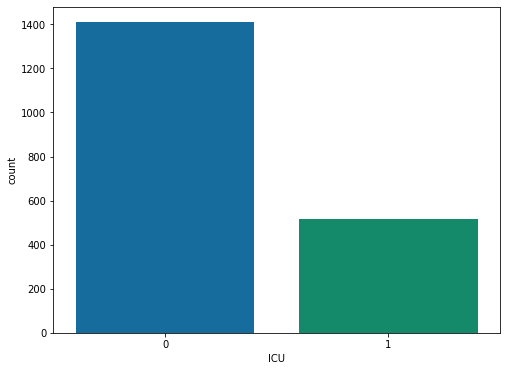

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.countplot(data=raw_df, x='ICU', ax=ax);

O Data set possui **1410 linhas possívelmente usáveis** (em que o paciente não foi para a UTI) e **515 linhas não-usáveis** (em que o paciente já havia sido encaminhado para a UTI).



In [ ]:
raw_df.isna().any().value_counts()

True     225
False      6
dtype: int64

Existem **225** colunas no dataset (aproximadamente 97%) que possuem valores NaN. 

Os autores do dataset comentaram sobre a existência de valores NaN no set de dados e indicaram o melhor caminho para resolver o problema:

> **Missing data**
**Problem**: One of the major challenges of working with health care data is that the sampling rate varies across different type of measurements. For instance, vital signs are sampled more frequently (usually hourly) than blood labs (usually daily).

> **Tips & Tricks**: It is reasonable to assume that a patient who does not have a measurement recorded in a time window **is clinically stable**, potentially presenting vital signs and blood labs similar to neighboring windows. Therefore, **one may fill the missing values using the next or previous entry**. Attention to multicollinearity and zero variance issues in this data when choosing your algorithm.

In [ ]:
# De acordo com os autores do dataset, utilizei o método de bfill/ffill

# Identificando as colunas que possuem NaNs
colunas_com_nan = raw_df.isna().sum()[raw_df.isna().sum() != 0].index.tolist()

# Utilizando o fillna para preencher os valores NaN nas colunas que os possuem; 
df_sem_nan = raw_df.copy()

df_sem_nan[colunas_com_nan] = df_sem_nan.groupby("PATIENT_VISIT_IDENTIFIER", as_index = False)[colunas_com_nan].fillna(method='bfill')
df_sem_nan[colunas_com_nan] = df_sem_nan.groupby("PATIENT_VISIT_IDENTIFIER", as_index = False)[colunas_com_nan].fillna(method='ffill')

df_sem_nan[colunas_com_nan].sample(10)

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,BILLIRUBIN_MAX,BILLIRUBIN_DIFF,BLAST_MEDIAN,...,DIMER_MEAN,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
1685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-1.0,0.086420,-0.346154,-0.231132,-0.423729,0.214286,0.710526,0.086420,-0.384615,-0.207547,-0.448276,0.178571,0.684211,0.237113,-0.1250,-0.179487,-0.357143,0.494505,0.878788,-0.247863,-0.459459,-0.373134,-0.393939,0.072464,0.789474,-1.000000,-0.877301,-0.923664,-0.882353,-0.904762,-0.959596,-1.000000,-0.869128,-0.946657,-0.884550,-0.906315,-0.959202
1848,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.975929,-0.975929,-0.975929,-0.975929,-1.0,-1.0,...,-0.996993,-0.996993,-0.996993,-1.0,0.209877,-0.369231,-0.452830,-0.525424,-0.250000,0.894737,0.209877,-0.369231,-0.452830,-0.517241,-0.250000,0.894737,0.340206,-0.1125,-0.316239,-0.428571,0.230769,0.959596,-0.162393,-0.556757,-0.567164,-0.575758,-0.391304,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,...,-0.978029,-0.978029,-0.978029,-1.0,0.160494,-0.338462,0.075472,-0.559322,0.107143,0.894737,0.160494,-0.338462,0.075472,-0.551724,0.107143,0.894737,0.298969,-0.0875,0.162393,-0.500000,0.450549,0.959596,-0.196581,-0.535135,-0.149254,-0.575758,-0.101449,0.894737,-1.000000,-1.000000,-1.000000,-0.941176,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.937327,-1.000000,-1.000000
1084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,-0.938950,-0.938950,-1.0,-1.0,...,-0.909340,-0.909340,-0.909340,-1.0,0.028807,-0.374359,-0.299528,-0.313559,0.096726,0.668860,0.086420,-0.384615,-0.301887,-0.517241,0.017857,0.684211,0.030928,

In [ ]:
# Checando número de linhas que restaram com NaN no dataset

df_sem_nan.isnull().sum().max()

10

In [ ]:
# Identificando as linhas que ainda possuem NaN

df_sem_nan[df_sem_nan.isnull().any(axis=1)]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
995,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
996,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-4,0
997,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
998,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-12,0
999,199,0,10th,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ABOVE_12,0
1435,287,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.111111,-0.630769,0.509434,-0.254237,0.107143,0.842105,-0.111111,-0.630769,0.509434,-0.241379,0.107143,0.842105,0.072165,-0.3250,0.555556,-0.142857,0.450549,0.939394,-0.384615,-0.740541,0.194030,-0.333333,-0.101449,0.842105,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1436,287,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.481481,-0.646154,0.037736,-0.457627,-0.160714,0.842105,-0.481481,-0.646154,0.037736,-0.448276,-0.160714,0.842105,-0.278351,-0.3375,0.094017,-0.428571,0.274725,0.939394,-0.60683

Como são apenas dois pacientes (e um deles com dados faltando), irei dropa-los do DF.

In [ ]:
df_sem_nan.dropna(inplace=True)

df_sem_nan.isna().any().value_counts()

False    231
dtype: int64

A maioria das variáveis do dataset são **quantitativas e contínuas**, por serem valores (pré-normalizados e escalonados) oriundos de exames.
<br>

Ainda assim, o dataset possui algumas váriaveis **categóricas** (como `GENDER`, `AGE_ABOVE65`, `AGE_PERCENTIL`, `DISEASE GROUPING i`, `WINDOW` e `ICU`). Enquanto a maior parte delas já são do tipo integer, ainda existem algumas do string:

In [ ]:
df_sem_nan.dtypes[df_sem_nan.dtypes == 'object']

AGE_PERCENTIL    object
WINDOW           object
dtype: object

A coluna `WINDOW` não será utilizada para criação do modelo, mas a `AGE_PERCENTIL` provavelmente sim.
<br>

Irei aplicar **one-hot-encoding** nela e em outras variáveis categóricas quando for preparar o dataset para ser usado no algoritmo.

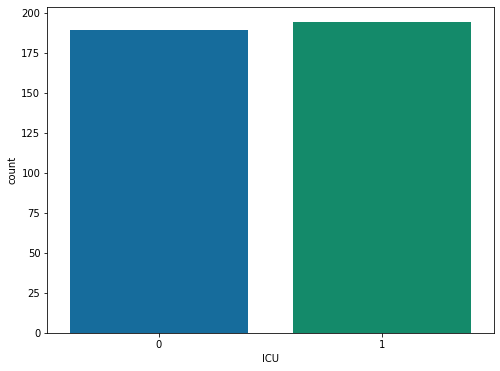

In [ ]:
# Countplot comparando a quantidade de pacientes do dataset que acabaram indo para a UTI em algum momento da visita

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(data = df_sem_nan.groupby('PATIENT_VISIT_IDENTIFIER').agg({'ICU': max}), x='ICU', ax=ax);

Entre os 383 pacientes, **194 deles foram encaminhados para a UTI** e 189 não. 

Podemos considerar uma distribuição de dados próxima o suficiente para elaborar algumas visualizações comparativas entre os grupos de pacientes.

In [ ]:
# Vamos agrupar os pacientes pelo uso da UTI e identificar algumas características
colunas_de_interesse = ['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65','AGE_PERCENTIL','GENDER','IMMUNOCOMPROMISED','RESPIRATORY_RATE_MEDIAN','DISEASE GROUPING 1',
                        'DISEASE GROUPING 2','DISEASE GROUPING 3','DISEASE GROUPING 4','DISEASE GROUPING 5','DISEASE GROUPING 6']


# Para realizar os comparativos, utilizarei os primeiros dados após a entrada da UTI para os pacientes ICU == 1
pacientes_uti = df_sem_nan[df_sem_nan['ICU'] == 1][colunas_de_interesse]\
                .drop_duplicates(subset = 'PATIENT_VISIT_IDENTIFIER', keep = 'first')

lista_id_pacientes_uti = pacientes_uti['PATIENT_VISIT_IDENTIFIER'].tolist()


# E de entrada no hospital para os pacientes ICU == 0
pacientes_nao_uti = df_sem_nan.query("PATIENT_VISIT_IDENTIFIER not in @lista_id_pacientes_uti")[colunas_de_interesse]\
                    .drop_duplicates(subset = 'PATIENT_VISIT_IDENTIFIER', keep = 'first')

pacientes_uti.sample(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,IMMUNOCOMPROMISED,RESPIRATORY_RATE_MEDIAN,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6
569,113,1,Above 90th,0,1.0,-0.448276,1.0,0.0,0.0,0.0,1.0,0.0
969,193,1,90th,0,0.0,-0.448276,0.0,0.0,0.0,0.0,0.0,0.0
1837,367,1,90th,1,0.0,-0.379310,1.0,0.0,1.0,0.0,1.0,0.0
1159,231,0,10th,0,0.0,-0.586207,0.0,0.0,0.0,0.0,0.0,0.0
1350,270,1,70th,0,0.0,-0.379310,0.0,0.0,0.0,0.0,0.0,0.0
183,36,1,70th,0,0.0,-0.241379,0.0,0.0,0.0,0.0,0.0,0.0
222,44,0,40th,0,1.0,-0.379310,0.0,0.0,1.0,1.0,0.0,0.0
436,87,1,Above 90th,0,0.0,0.034483,0.0,0.0,0.0,0.0,0.0,0.0
1689,337,0,20th,0,0.0,-0.172414,0.0,0.0,0.0,0.0,0.0,0.0
974,194,1,80th,0,1.0,-0.586207,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
pacientes_nao_uti.sample(10)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,IMMUNOCOMPROMISED,RESPIRATORY_RATE_MEDIAN,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6
1120,224,1,60th,1,0.0,-0.517241,0.0,0.0,0.0,0.0,0.0,0.0
1605,321,1,60th,1,0.0,-0.310345,0.0,0.0,0.0,0.0,0.0,0.0
415,83,1,70th,0,1.0,-0.517241,0.0,0.0,1.0,0.0,0.0,0.0
1385,277,0,10th,0,0.0,-0.517241,0.0,0.0,0.0,0.0,0.0,0.0
325,65,0,20th,0,0.0,-0.586207,0.0,0.0,0.0,0.0,0.0,0.0
1775,355,0,40th,0,0.0,-0.379310,0.0,0.0,0.0,0.0,0.0,0.0
460,92,0,10th,1,0.0,-0.379310,0.0,0.0,0.0,0.0,0.0,0.0
770,154,0,40th,1,0.0,-0.517241,0.0,0.0,0.0,0.0,0.0,0.0
640,128,0,30th,0,0.0,-0.517241,0.0,0.0,0.0,0.0,0.0,0.0
1515,303,0,40th,1,1.0,-0.586207,0.0,0.0,0.0,0.0,0.0,0.0


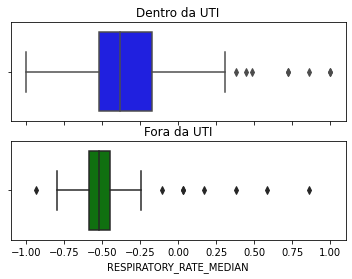

In [ ]:
fig, axs = plt.subplots(2, sharex=True, sharey=True)

sns.boxplot(data = pacientes_uti, x = 'RESPIRATORY_RATE_MEDIAN', ax = axs[0], color='b');
sns.boxplot(data = pacientes_nao_uti, x = 'RESPIRATORY_RATE_MEDIAN', ax = axs[1], color = 'g');

axs[0].set_title('Dentro da UTI')
axs[0].set_xlabel('')
axs[1].title.set_text('Fora da UTI')

É possível verificar uma diferença na **frequência respiratória** de pacientes que acabaram sendo encaminhados pra UTI (**valores medianos em uma distribuição espalhada**) quando comparados com aqueles que **não foram (que possuem os valores em uma distribuição mais achatada)**.

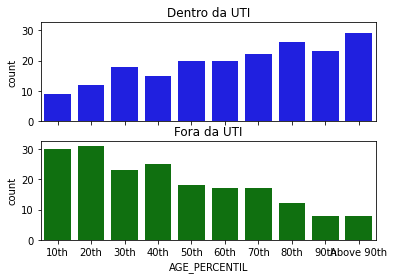

In [ ]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, squeeze = True)

ordem = ['10th', '20th','30th','40th','50th','60th','70th','80th','90th','Above 90th']

sns.countplot(data=pacientes_uti, x='AGE_PERCENTIL', ax=axs[0], order=ordem, color = 'b');
sns.countplot(data=pacientes_nao_uti, x='AGE_PERCENTIL', ax=axs[1], order=ordem, color = 'g');

axs[0].set_title('Dentro da UTI')
axs[0].set_xlabel('')
axs[1].title.set_text('Fora da UTI')

Dá pra ver uma diferença explícita na distribuição da idade dos pacientes que necessitaram da UTI para aqueles que não precisaram. Em geral, **quanto mais velho o paciente, maior a chance dele precisar ser internado**. A inversa também é válida.

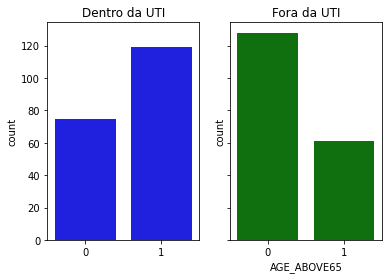

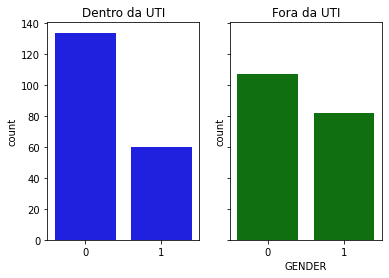

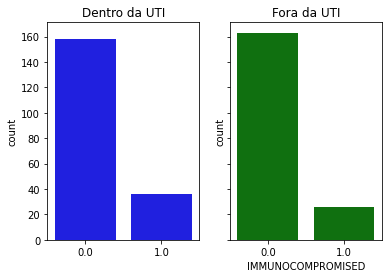

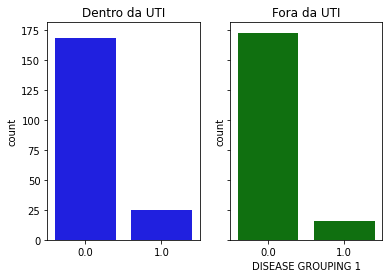

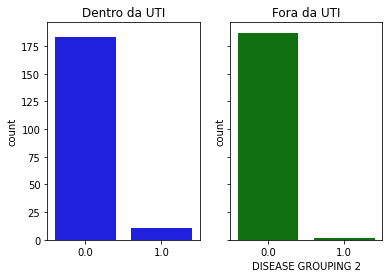

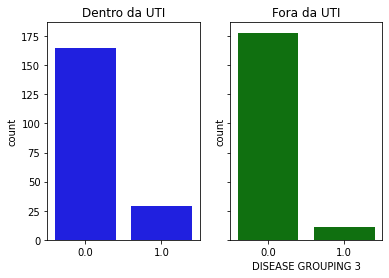

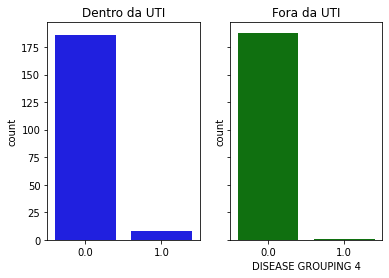

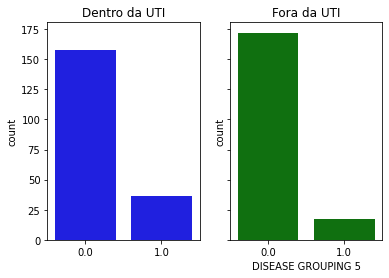

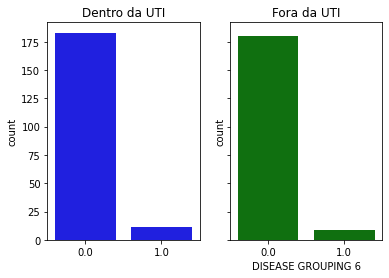

In [ ]:
colunas_binarias = [
 'AGE_ABOVE65',
 'GENDER',
 'IMMUNOCOMPROMISED',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6']

for col in colunas_binarias:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, squeeze = True)

    sns.countplot(data=pacientes_uti, x=col, ax=axs[0], color = 'b');
    sns.countplot(data=pacientes_nao_uti, x=col, ax=axs[1], color = 'g');
    
    
    plt.title(f'Distribuição na {col}')
    
    axs[0].set_title('Dentro da UTI')
    axs[0].set_xlabel('')
    axs[1].title.set_text('Fora da UTI')

* AGE_ABOVE65 - **Pessoas acima de 65 anos são mais comuns dentro da UTI**, como era esperado pelos resultados do countplot da coluna 'AGE_PERCENTIL'.
* GENDER - Apesar de pessoas do **gênero '0'** serem mais comuns em ambos subsets, **elas são ainda mais comuns dentro da UTI**.
* IMMUNOCOMPROMISED e DISEASE GROUPING i - As **distribuições são parecidas entre os subsets**, mas é válido a observação de que **pessoas positivas** (com a exceção da coluna DISEASE GROUPING 6) são **mais comuns no set de pessoas que foram encaminhadas para a UTI**.

O dataset possui diversas váriaveis que foram expandidas para **média, max, min, diff, relative_diff**. 
<br>

Por causa disso, essas variáveis podem acabam tendo **valores correlacionados** e a **perfomance** de alguns **algoritmos** de classificação (principalmente os lineares) seria **afetada negativamente**. Para confirmar a existência dessas váriaveis altamente correlacionadas, utilizarei a função do livro **Machine Learning Pocket Reference**, escrito por *Matt Harrison*, que mostra as colunas correlacionadas dado algum limite mínimo de **correlação pearson**.

In [ ]:
pd.set_option("display.max_rows", None)
colunas_correlacionadas(df_sem_nan)

,level_0,level_1,pearson
3,ALBUMIN_MAX,ALBUMIN_MEDIAN,1.000000
4,ALBUMIN_MAX,ALBUMIN_MEAN,1.000000
5,ALBUMIN_MAX,ALBUMIN_MIN,1.000000
9,BE_ARTERIAL_MAX,BE_ARTERIAL_MEDIAN,1.000000
10,BE_ARTERIAL_MAX,BE_ARTERIAL_MEAN,1.000000
11,BE_ARTERIAL_MAX,BE_ARTERIAL_MIN,1.000000
15,BE_VENOUS_MAX,BE_VENOUS_MEDIAN,1.000000
16,BE_VENOUS_MAX,BE_VENOUS_MEAN,1.000000
17,BE_VENOUS_MAX,BE_VENOUS_MIN,1.000000
21,BIC_ARTERIAL_MAX,BIC_ARTERIAL_MEDIAN,1.000000


Mesmo utilizando um *threshold* alto na função, ela retorna **centenas de colunas** altamente relacionadas entre si.

### Processamento dos Dados

Esse dataset foi produzido para uso futuro e, por causa disso, muitos dos dados que estão na base não podem ser utilizados na produção do modelo.
Farei a limpeza de acordo com os autores.
* **Retirar** do dataset **pacientes que entraram direto para a UTI**;
* Organizar o dataset para o uso na criação do modelo:
    * Adicionar uma coluna marcando que o **paciente foi parar na UTI em algum momento**;
    * Retirar dados coletados a partir de `WINDOW` = 0-2.
    * Aplicar **One-Hot-Encoding** nas **colunas categóricas** que necessitarem;
* Remover do dataset as colunas que não devem ser usadas no modelo: `WINDOW`,`PACIENT_VISIT_IDENTIFIER`;
* Remover do dataset colunas **baixariam a perfomance** do modelo (**alta correlação**, **valor constante**).

1. Retirar do data set pacientes que entraram direto para a UTI; 

In [ ]:
# Para retirar os pacientes que entraram na UTI, utilizei um query em que a Window era 0-2 e o ICU igual a 1;

pacientes_a_remover = df_sem_nan.query("WINDOW == '0-2' & ICU == 1")["PATIENT_VISIT_IDENTIFIER"]
df_processado = df_sem_nan.query("PATIENT_VISIT_IDENTIFIER not in @pacientes_a_remover")

In [ ]:
# Checando se a retirada dos pacientes foi correta

pd.crosstab(df_processado['WINDOW'], df_processado['ICU'])

ICU,0,1
WINDOW,,
0-2,351,0
2-4,324,27
4-6,284,67
6-12,253,98
ABOVE_12,189,162


2. Organizar o dataset para o uso na criação do modelo

2.1 Adicionar uma coluna marcando que o **paciente foi parar na UTI em algum momento**;

> Problem: Early identification of those patients who will develop an adverse course of illness (and need intensive care) is a key for an appropriate treatment (saving lives) and to managing beds and resources.

> Tips & Tricks: Whereas a predictive model using all time windows will probably yield a greater accuracy, a nice model using only the first (0-2) is likely to be more clinically relevant. The creativity is very welcome though, please feel free with feature engineering and time windows. Attention to repeated measures on individuals once these values are (positively) correlated when playing around with data.

Os autores do dataset mostraram interesse em um **modelo treinado usando apenas os dados de pacientes coletados janela entre [0-2] horas**.
Além disso, também deixaram claro que a coluna janela (caso fossem usados os dados de pacientes em outras janelas, o que aqui não será o caso) e as linhas em pacientes estão internados não deveriam ser usada no treinamento do modelo.

2.2 Retirar dados coletados a partir de `WINDOW` = 0-2.

In [ ]:
# Pacientes que foram pra UTI depois da janela de 2 hrs
paciente_uti = df_processado.groupby('PATIENT_VISIT_IDENTIFIER').agg({'ICU': max}).rename(columns={'ICU': 'ICU_ANYTIME'})
paciente_uti
    
# Adicionando a coluna criada acima no df
df_processado = df_processado.merge(paciente_uti, on=['PATIENT_VISIT_IDENTIFIER'], how = 'right')

# Mantendo apenas os dados de pacientes entre [0-2]
df_processado = df_processado[df_processado['WINDOW'] == '0-2']

Vamos adicionar criar um segundo dataset utilizando features recomendadas pelos autores do dataset.

In [ ]:
df_bio =  makebio_df(df_processado)

df_bio.sample(10)

,ICU_ANYTIME,AGE_ABOVE65,GENDER,BLOODPRESSURE_ARTERIAL_MEAN,RESPIRATORY_RATE_MAX,HTN,P02_ARTERIAL_MEAN,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,GASO,OXYGEN_SATURATION_MIN,HEART_RATE_MAX,PCR_MEAN,CREATININ_MEAN
680,1,1,0,0.031972,-0.515152,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.858586,-0.477612,-0.910397,-0.797594
400,1,0,0,-0.290535,-0.636364,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.838384,-0.074627,-0.266919,-0.936306
675,0,1,0,-0.619120,-0.575758,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.858586,-0.417910,-0.932703,-0.756546
1085,0,0,0,-0.143716,-0.696970,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.939394,-0.716418,-0.973157,-0.868365
220,0,1,1,0.213042,-0.333333,0.0,-0.170732,1.0,0.0,0.0,0.0,0.0,0.0,1,0.919192,-0.074627,-0.887335,-0.933475
1415,0,1,0,-0.337765,-0.575758,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.838384,-0.432836,-0.705860,-0.899505
510,0,0,1,-0.452991,-0.696970,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.959596,-0.283582,-0.982231,-0.908402
1065,1,1,0,-0.232479,-0.454545,1.0,-0.804878,0.0,0.0,0.0,0.0,0.0,0.0,1,0.939394,-0.313433,-0.400000,-0.875442
655,0,0,0,0.145299,-0.515152,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.919192,-0.552239,-0.757656,-0.926398
1210,1,0,0,0.367775,-0.090909,0.0,-0.170732,0.0,0.0,0.0,0.0,0.0,0.0,1,0.838384,-0.119403,-0.298677,-0.909413


In [ ]:
# Remover coluna com apenas 1 valor

print(df_bio['GASO'].nunique())
df_bio.drop('GASO', axis = 1, inplace = True)

1


2.3 One-Hot-encoding na coluna `AGE_PERCENTIL`, a única com strings, e `GENDER` e `AGE_ABOVE65`, por serem **categóricas**.<br>
3. Remover do dataset as colunas que não devem ser usadas no modelo: `WINDOW`,`PACIENT_VISIT_IDENTIFIER`;

In [ ]:
# Apagando colunas ICU(antiga), WINDOW e PATIENT_VISIT_IDENTIFIER

df_processado.drop('ICU', axis=1, inplace=True)
df_processado.drop('WINDOW', axis=1, inplace=True)
df_processado.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)


# Transformando GENDER e AGE_ABOVE65 em strings para serem processados pelo get_dummies()
df_processado['GENDER'] = df_processado['GENDER'].astype(str)
df_processado['AGE_ABOVE65'] = df_processado['AGE_ABOVE65'].astype(str)
df_processado = pd.get_dummies(df_processado, columns=['GENDER','AGE_PERCENTIL','AGE_ABOVE65'], prefix=['GENDER','AGE_PERCENTIL','AGE_ABOVE65'])

# Recriando a coluna ICU com os valores novos e dropando a cópia
for df in [df_processado, df_bio]:
    df['ICU'] = df['ICU_ANYTIME']
    df.drop('ICU_ANYTIME', axis=1, inplace=True)

4. Remover do dataset colunas **baixariam a perfomance** do modelo (**alta correlação**, **valor constante**).

In [ ]:
df_modelo = df_processado.copy()

# Criar lista com colunas que possuem valor constante
colunas_const = list(df_modelo.columns[df_modelo.nunique() == 1])

# Dropar do dataset que vai ser usado na modelagem
for col in colunas_const:
    df_modelo.drop(col, axis=1, inplace=True, errors='ignore')

In [ ]:
# Criarei um df_modelo_mediana onde utilizarei apenas a mediana das medições
df_modelo_mediana = df_modelo.copy()

for col in df_modelo_mediana.columns:
    if any(x in col for x in ['_MAX', '_MIN', '_MEAN']):
            df_modelo_mediana.drop(col, axis=1, inplace=True, errors='ignore')

In [ ]:
# Remover as colunas com alta correlação

for col in colunas_correlacionadas(df_modelo, threshold = 0.90)["level_1"]:
    df_modelo.drop(col, axis=1, inplace=True, errors='ignore')

A correlação será um problema principalmente para modelos **lineares**, como LogisticRegression, que será usado apenas como baseline. Ainda assim, vou verificar caso tenha sobrado alguma coluna com alta correlação no modelo em que mantivemos apenas as medianas.

In [ ]:
pd.set_option("display.max_rows", None)
colunas_correlacionadas(df_modelo_mediana, threshold = 0.90)

,level_0,level_1,pearson
0,HEMOGLOBIN_MEDIAN,HEMATOCRITE_MEDIAN,0.975860
1,NEUTROPHILES_MEDIAN,LEUKOCYTES_MEDIAN,0.962695
2,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_DIASTOLIC_DIFF,0.978502
3,BLOODPRESSURE_SISTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF,0.990591
4,HEART_RATE_DIFF_REL,HEART_RATE_DIFF,0.949897
5,RESPIRATORY_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF,0.961726
6,TEMPERATURE_DIFF_REL,TEMPERATURE_DIFF,0.999444
7,OXYGEN_SATURATION_DIFF_REL,OXYGEN_SATURATION_DIFF,0.998889
8,GENDER_1,GENDER_0,-1.000000
9,AGE_ABOVE65_1,AGE_ABOVE65_0,-1.000000


### Análise Exploratória dos Dados que serão usados no Modelo

0    189
1    162
Name: ICU, dtype: int64

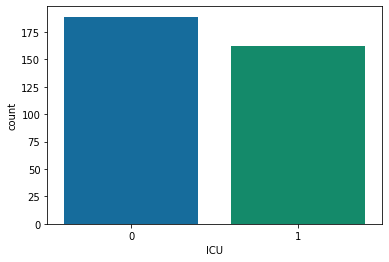

In [ ]:
sns.countplot(data=df_modelo, x='ICU');

df_modelo['ICU'].value_counts()

Após a limpeza dos dados, o dataset que será utilizado no modelo possui 189 pacientes que não precisaram da UTI e 162 que precisaram.

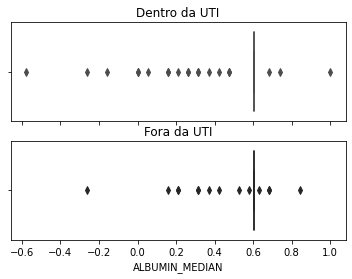

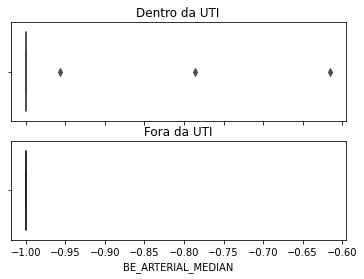

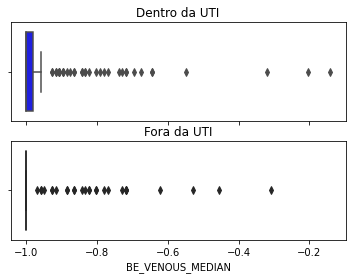

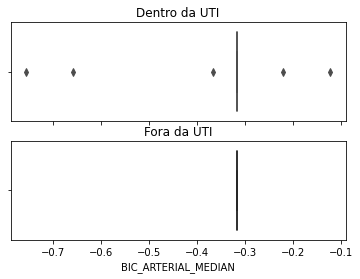

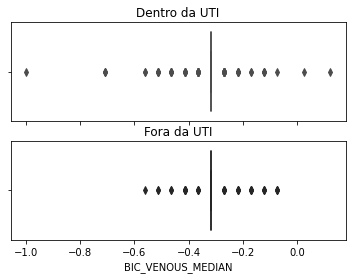

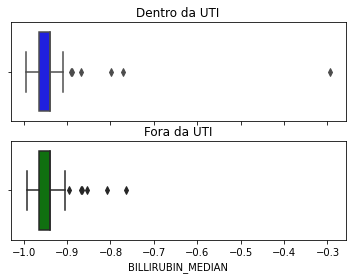

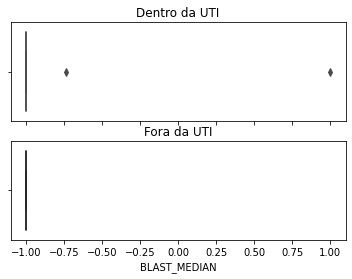

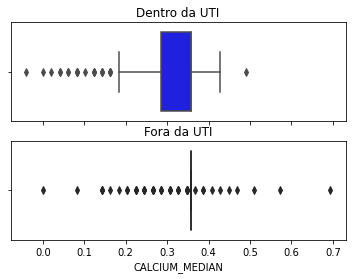

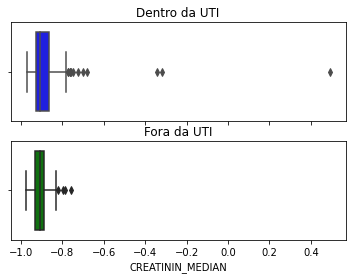

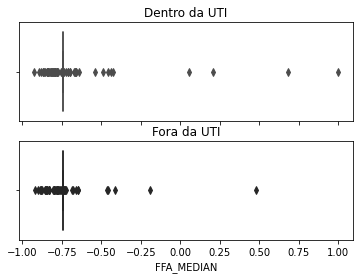

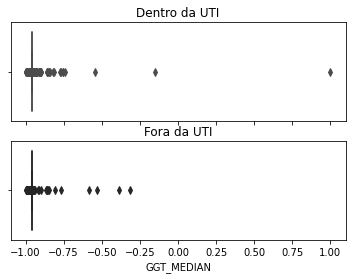

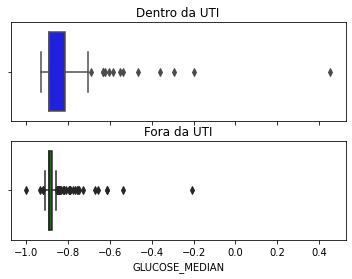

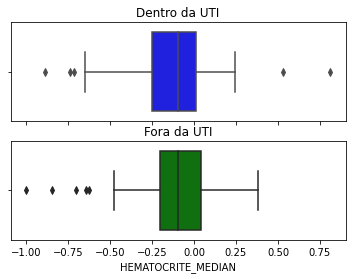

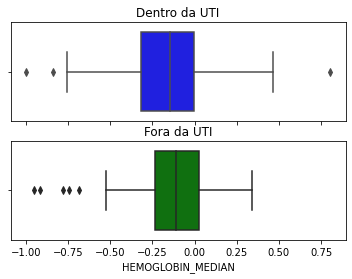

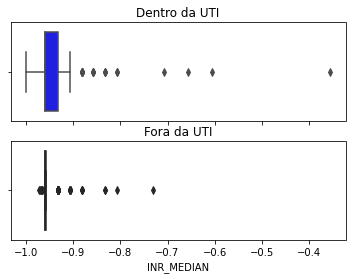

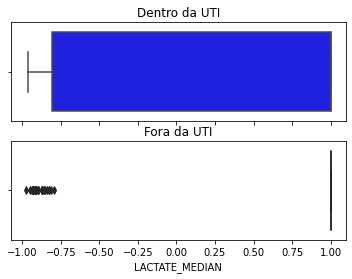

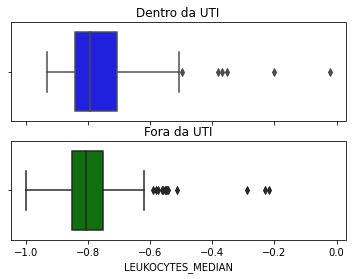

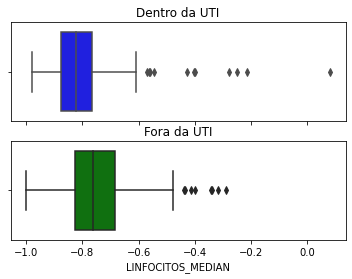

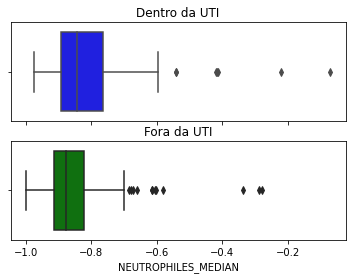

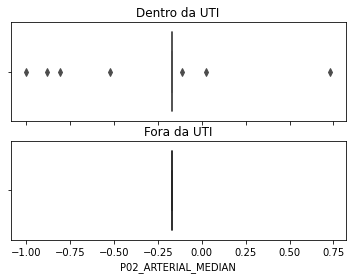

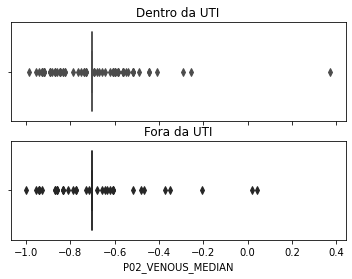

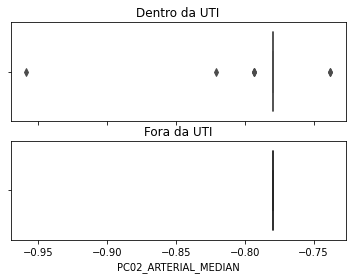

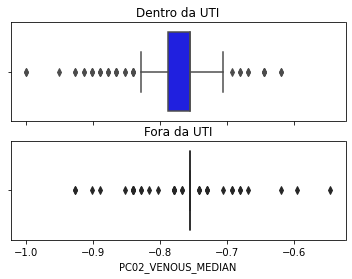

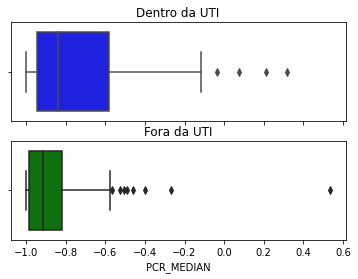

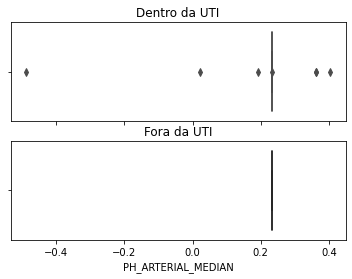

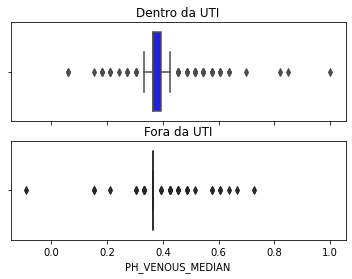

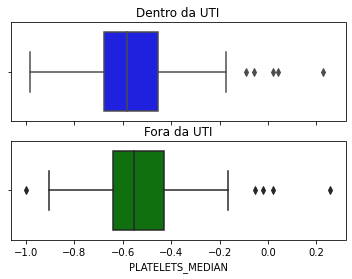

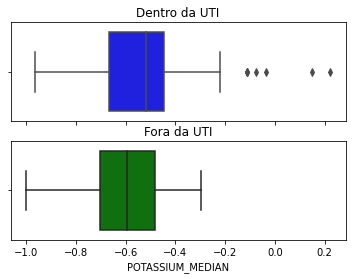

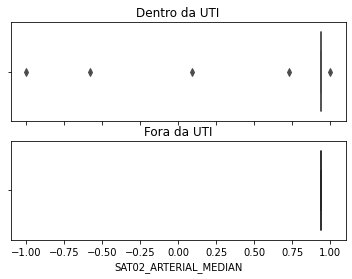

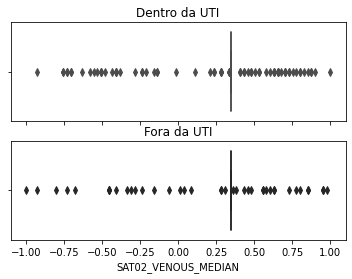

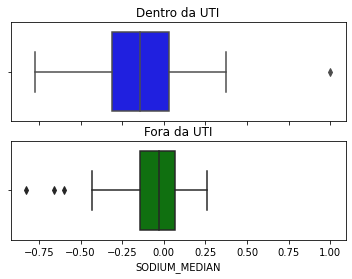

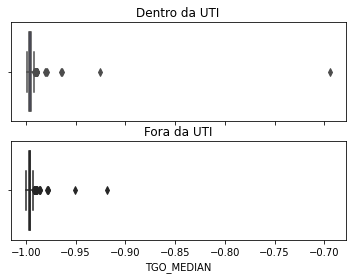

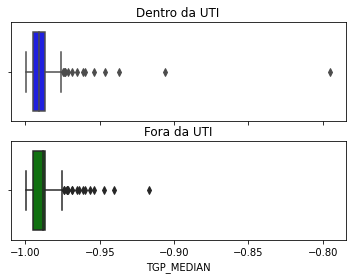

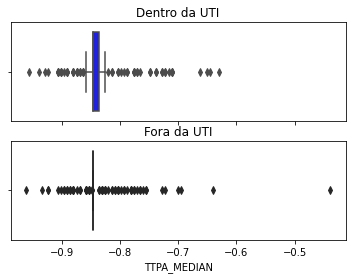

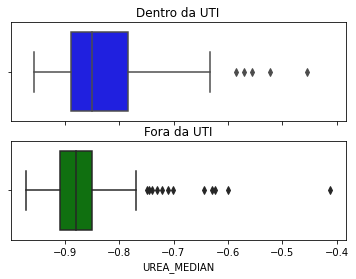

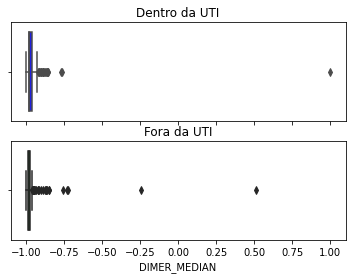

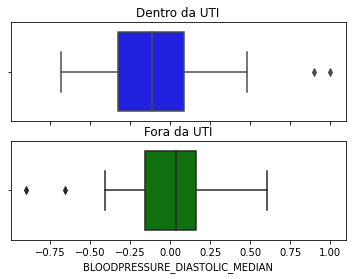

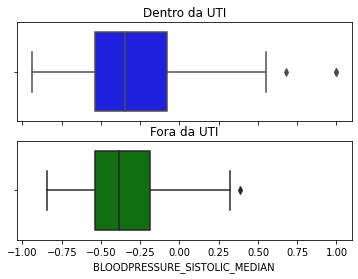

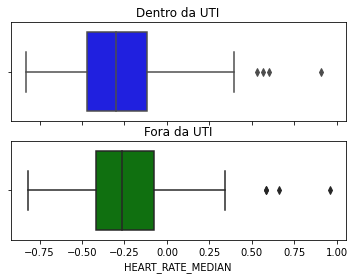

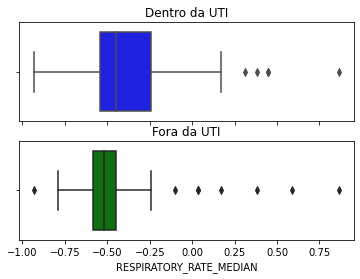

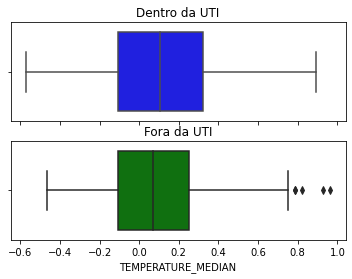

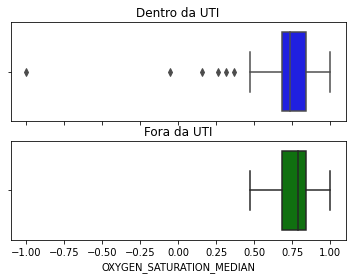

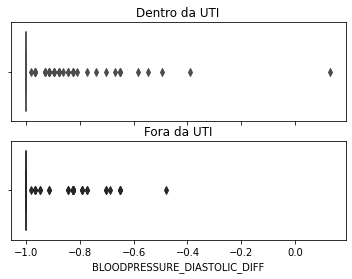

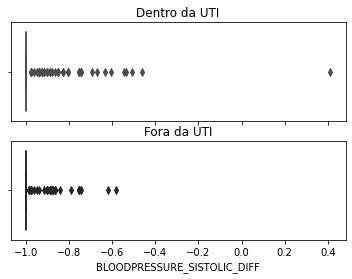

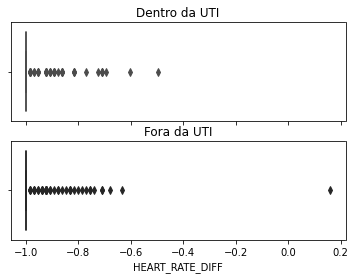

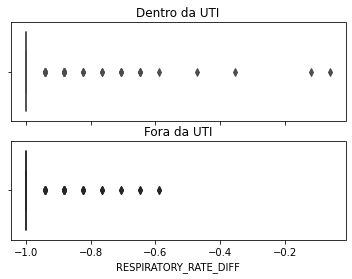

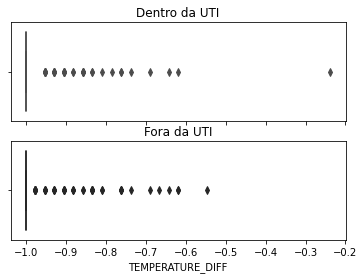

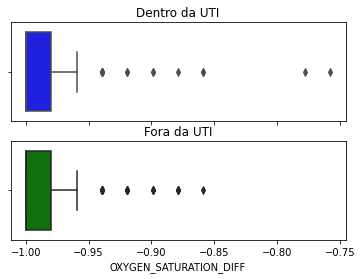

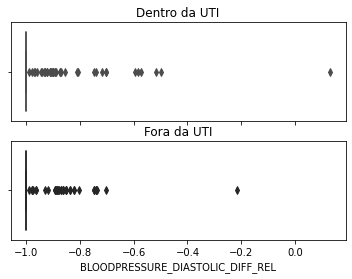

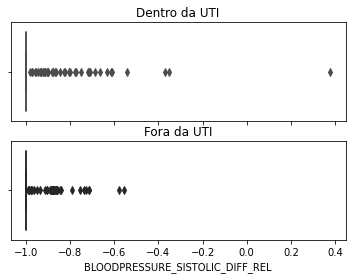

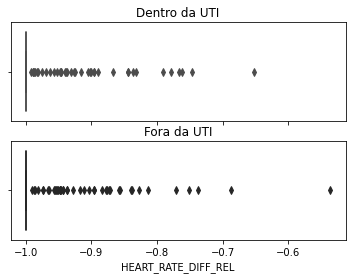

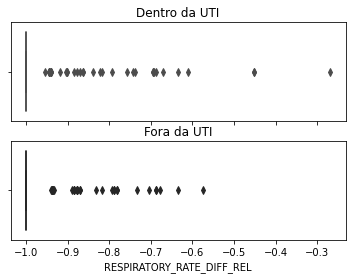

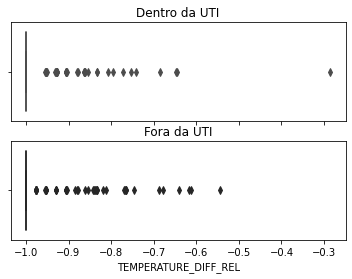

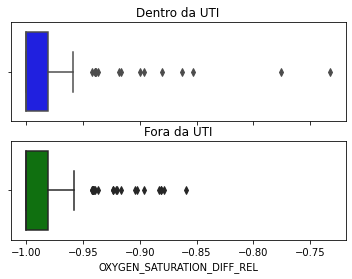

In [ ]:
variaveis_continuas = list(df_modelo_mediana.iloc[:, 9:-15].columns)

for col in variaveis_continuas:
    fig, axs = plt.subplots(2, sharex=True, sharey=True)

    sns.boxplot(data = df_modelo_mediana[df_modelo['ICU'] == 1], x = col, ax = axs[0], color = 'b');
    sns.boxplot(data = df_modelo_mediana[df_modelo['ICU'] == 0], x = col, ax = axs[1], color = 'g');

    axs[0].set_title('Dentro da UTI')
    axs[0].set_xlabel('')
    axs[1].title.set_text('Fora da UTI')

Para observar as distribuições das váriaveis contínuas, utilizei o dataset em que foram cortados as features _MIN, _MAX e _MEAN por possuir maior número de váriaveis. Além disso, a tabela de correlações mostra que o comportamento das features cortadas é quase idêntico ao daquelas que sobraram. 

A minha leiguisse, combinada com a pré-normalização dos valores das váriaveis, não me permite entender o que cada um dos plots significa cientificamente. Ainda assim, dá pra perceber diferenças na maioria das features quando comparamos as distribuições de valores entre as pessoas que acabaram precisando da UTI com aquelas que não. As features que tiveram a maior diferença entre as ditribuições foram:
* LACTATE_MEDIAN
* LEUKOCYTES_MEDIAN
* LINFOCITOS_MEDIAN
* PCR_MEDIAN
* PLATELETS_MEDIAN
* POTASSIUM_MEDIAN
* SODIUM_MEDIAN
* RESPIRATORY_RATE_MEDIAN

Algumas features, entretanto, obtiveram distribuições quase idênticas entre os grupos de pacientes:
* BE_VENOUS_MEDIAN
* CALCIUM_MEDIAN
* HEMOGLOBIN_MEDIAN
* P02_VENOUS_MEDIAN
* SAT02_VENOUS_MEDIAN
* HEART_RATE_MEDIAN

In [ ]:
features_dist_identicas = ['BE_VENOUS_MEDIAN', 'CALCIUM_MEDIAN', 'HEMOGLOBIN_MEDIAN', 'P02_VENOUS_MEDIAN', 'SAT02_VENOUS_MEDIAN', 'HEART_RATE_MEDIAN']

features_proximas_c_outliers_expressivos = ['ALBUMIN_MEDIAN','BE_ARTERIAL_MEDIAN','BIC_ARTERIAL_MEDIAN','BIC_VENOUS_MEDIAN',
'BILLIRUBIN_MEDIAN','BLAST_MEDIAN','FFA_MEDIAN','GGT_MEDIAN','CREATININ_MEDIAN', 'P02_ARTERIAL_MEDIAN','PC02_ARTERIAL_MEDIAN',
'PH_ARTERIAL_MEDIAN','SAT02_ARTERIAL_MEDIAN','TGO_MEDIAN','TGP_MEDIAN','TTPA_MEDIAN','DIMER_MEDIAN','OXYGEN_SATURATION_MEDIAN',
'BLOODPRESSURE_DIASTOLIC_DIFF','BLOODPRESSURE_SISTOLIC_DIFF','HEART_RATE_DIFF','RESPIRATORY_RATE_DIFF','TEMPERATURE_DIFF',
'OXYGEN_SATURATION_DIFF','BLOODPRESSURE_DIASTOLIC_DIFF_REL','BLOODPRESSURE_SISTOLIC_DIFF_REL','HEART_RATE_DIFF_REL',
'RESPIRATORY_RATE_DIFF_REL','TEMPERATURE_DIFF_REL','OXYGEN_SATURATION_DIFF_REL']

featuers_dist_diferentes = ['GLUCOSE_MEDIAN','HEMATOCRITE_MEDIAN','INR_MEDIAN','LACTATE_MEDIAN',
'LEUKOCYTES_MEDIAN','LINFOCITOS_MEDIAN','NEUTROPHILES_MEDIAN','PC02_VENOUS_MEDIAN',
'PCR_MEDIAN','PH_VENOUS_MEDIAN','PLATELETS_MEDIAN','POTASSIUM_MEDIAN','SODIUM_MEDIAN','UREA_MEDIAN',
'BLOODPRESSURE_DIASTOLIC_MEDIAN','BLOODPRESSURE_SISTOLIC_MEDIAN','RESPIRATORY_RATE_MEDIAN','TEMPERATURE_MEDIAN']

### Definindo o modelo baseline

Em primeiro momento, irei testar a perfomance de um modelo de **Logistic Regression** no primeiro dataset para servir como um **baseline**. Em seguida, vou comparar os resultados do mesmo modelo no segundo dataset, em que apenas as medianas foram utilizadas. 

A função utilizada para instanciar e avaliar os modelos itera `50` vezes e retorna a mediana dos scores.

In [ ]:
dfs = [('DF CORR CORTADA',df_modelo),('DF MEDIANA',df_modelo_mediana),('DF BIO',df_bio)]

for df in dfs:
    print(f"==== SCORE {df[0]} =====")
    lr_scores = exec_modelagem(df[1], LogisticRegression, n_iter = 50, resumo = True)
    display(lr_scores)

==== SCORE DF CORR CORTADA =====


ROC (AUC)                 0.765698
Sensibilidade - Recall    0.646341
Especificidade            0.710101
F1-score                  0.666667
Precisão                  0.697826
Acurácia                  0.710227
dtype: float64

==== SCORE DF MEDIANA =====


ROC (AUC)                 0.768293
Sensibilidade - Recall    0.658537
Especificidade            0.710591
F1-score                  0.676056
Precisão                  0.701852
Acurácia                  0.710227
dtype: float64

==== SCORE DF BIO =====


ROC (AUC)                 0.747794
Sensibilidade - Recall    0.585366
Especificidade            0.679245
F1-score                  0.631579
Precisão                  0.694444
Acurácia                  0.681818
dtype: float64

Os resultados foram parecidos, com exceção do `df_bio`. No entanto, utilizarei como baseline os resultados da segunda execução. Devido à natureza da task, os scores ROC e sensibilidade são os mais importantes.

| BASELINE LR - DF MEDIANA 	|  SCORES  	|
|:----------------------------------:	|:--------:	|
|              ROC (AUC)             	| 0.768293 	|
|       Sensibilidade - Recall       	| 0.658537 	|
|           Especificidade           	| 0.710591 	|
|              F1-score              	| 0.676056 	|
|              Precisão              	| 0.701852 	|
|              Acurácia              	| 0.710227 	|

### 10-Fold Cross-Validation

Vou utilizar um algoritmo 10-fold cross-validation para verificar qual algoritmo - utilizando hiperparametrização padrão - desempenhará melhor nos datasets. Utilizei os scores ROC(AUC), Recall e F1 para realizar a comparação. 

In [ ]:
for df in dfs:
    X = df[1].drop('ICU', axis=1)
    y = df[1]['ICU']
    print(f"==== SCORE {df[0]} =====")
    display(kfold_cross_validation(X,y))

==== SCORE DF CORR CORTADA =====


,model,ROC (AUC) MEDIANA,ROC (AUC) STD,Sensibilidade - Recall MEDIANA,Sensibilidade - Recall STD,F1-score MEDIANA,F1-score STD
0,DecisionTreeClassifier,0.544,0.09,0.445,0.14,0.475,0.12
1,KNeighborsClassifier,0.699,0.08,0.559,0.11,0.593,0.08
2,GaussianNB,0.713,0.05,0.155,0.08,0.254,0.11
3,SVC,0.775,0.07,0.655,0.11,0.679,0.09
4,RandomForestClassifier,0.784,0.07,0.679,0.11,0.688,0.09
5,XGBClassifier,0.785,0.07,0.677,0.09,0.710,0.09


==== SCORE DF MEDIANA =====


,model,ROC (AUC) MEDIANA,ROC (AUC) STD,Sensibilidade - Recall MEDIANA,Sensibilidade - Recall STD,F1-score MEDIANA,F1-score STD
0,DecisionTreeClassifier,0.604,0.09,0.550,0.15,0.567,0.12
1,KNeighborsClassifier,0.689,0.07,0.500,0.09,0.561,0.08
2,GaussianNB,0.721,0.06,0.155,0.09,0.261,0.12
3,SVC,0.758,0.07,0.679,0.13,0.644,0.10
4,RandomForestClassifier,0.782,0.06,0.735,0.11,0.742,0.10
5,XGBClassifier,0.808,0.07,0.702,0.11,0.694,0.09


==== SCORE DF BIO =====


,model,ROC (AUC) MEDIANA,ROC (AUC) STD,Sensibilidade - Recall MEDIANA,Sensibilidade - Recall STD,F1-score MEDIANA,F1-score STD
0,DecisionTreeClassifier,0.654,0.06,0.688,0.13,0.629,0.08
1,KNeighborsClassifier,0.704,0.09,0.517,0.10,0.578,0.09
2,GaussianNB,0.755,0.06,0.129,0.10,0.223,0.15
3,SVC,0.742,0.05,0.692,0.10,0.675,0.08
4,RandomForestClassifier,0.771,0.05,0.683,0.11,0.679,0.06
5,XGBClassifier,0.759,0.04,0.649,0.09,0.690,0.04


Nos 3 datasets, os algoritmos **RandomForest** e o **XGBoost** apresentaram resultados melhores que os outros algoritmos testados. A exceção fica com o dataset que passou pela função criada pelo time do Sirío Libanês, que teve um scores maiores no SVC que no XGBoost.
<br>

O **RandomForest** performou expressivamente melhor no dataset número 2, em que cortamos o manualmente algumas das colunas, no recall e F1. Já o XGBoost obteve alguns scores melhores no dataset 1 (ROC e F1) e outro no dataset 2 (sensibilidade).

### Random Forest

Inicialmente, instanciarei o RandomForest no dataset com diferentes seleções de features e com hiperparametrização padrão. Em seguida, utilizarei o GridSearch para realizar o ajuste dos hiperparâmetros.

In [ ]:
for df in dfs:
    print(f"==== SCORE {df[0]} RANDOM FOREST DEFAULT =====")
    display(exec_modelagem(df[1], RandomForestClassifier, n_iter = 50, resumo = True))

==== SCORE DF CORR CORTADA RANDOM FOREST DEFAULT =====


ROC (AUC)                 0.799299
Sensibilidade - Recall    0.658537
Especificidade            0.726381
F1-score                  0.693333
Precisão                  0.720398
Acurácia                  0.727273
dtype: float64

==== SCORE DF MEDIANA RANDOM FOREST DEFAULT =====


ROC (AUC)                 0.796056
Sensibilidade - Recall    0.682927
Especificidade            0.737925
F1-score                  0.705214
Precisão                  0.711111
Acurácia                  0.727273
dtype: float64

==== SCORE DF BIO RANDOM FOREST DEFAULT =====


ROC (AUC)                 0.764660
Sensibilidade - Recall    0.658537
Especificidade            0.715769
F1-score                  0.675325
Precisão                  0.707317
Acurácia                  0.704545
dtype: float64


| RANDOM FOREST DEFAULT - DF MEDIANA 	|  SCORES  	|
|:----------------------------------:	|:--------:	|
|              ROC (AUC)             	| 0.796056 	|
|       Sensibilidade - Recall       	| 0.682927 	|
|           Especificidade           	| 0.737925 	|
|              F1-score              	| 0.705214 	|
|              Precisão              	| 0.711111 	|
|              Acurácia              	| 0.727273 	|

### Testes Cortando o Dataset

Durante o EDA dos datasets que seriam utilizados na modelagem, identifiquei nas features contínuas alguns comportamentos diferentes quanto às distribuições ao comparar os pacientes dentro e fora da UTI. Antes de fazer o ajuste dos hiperparâmetros, irei testar se cortar algumas features do dataset 2 trará benefícios ao modelo.

In [ ]:
# Dataset 2 sem as features que possuíam distribuições iguais entre pacientes dentro e fora da UTI
df_modelo_mediana_corte = df_modelo_mediana.drop(features_dist_identicas, axis = 1)

# Dataset 2 apenas com as features que possuíam distribuições expressivamente diferentes entre pacientes dentro e fora da UTI
df_modelo_mediana_apenas_dif = df_modelo_mediana_corte.drop(features_proximas_c_outliers_expressivos, axis = 1)

dfs_de_testes = [('TESTE 1 - elimina features c/ distribuições iguais entre pacientes de ambas labels',df_modelo_mediana_corte),
                 ('TESTE 2 - Mantém features c/ distribuições expressivamente diferentes entre os pacientes',df_modelo_mediana_apenas_dif)]

In [ ]:
for df in dfs_de_testes:
    print(f"==== SCORE {df[0]} - RANDOM FOREST DEFAULT =====")
    display(exec_modelagem(df[1], RandomForestClassifier, n_iter = 50, resumo = True))

==== SCORE TESTE 1 - elimina features c/ distribuições iguais entre pacientes de ambas labels - RANDOM FOREST DEFAULT =====


ROC (AUC)                 0.796964
Sensibilidade - Recall    0.682927
Especificidade            0.734591
F1-score                  0.696064
Precisão                  0.721576
Acurácia                  0.727273
dtype: float64

==== SCORE TESTE 2 - Mantém features c/ distribuições expressivamente diferentes entre os pacientes - RANDOM FOREST DEFAULT =====


ROC (AUC)                 0.786715
Sensibilidade - Recall    0.682927
Especificidade            0.733333
F1-score                  0.696064
Precisão                  0.705010
Acurácia                  0.715909
dtype: float64

Os scores foram próximos entre os testes e o teste 1 retornou como mediana de 50 testes os resultados muito similares ao dataset pré corte de features. Imagino que pela distribuição dessas features serem idênticas entre ambas as classificações, algoritmos não lineares como Random Forests e o XGBoost não tenham sua perfomance afetada. Devido ao menor número de features facilitar a explicabilidade do modelo, utilizarei o `df_mediana` após o teste 1 e o `df_bio` na hiperparâmetrização.

### GridSearch - RandomForest

De acordo com o livro **Introduction to Machine Learning with Python**, o algoritmo RandomForest é relativamente robusto à alterações nos seus hiperparametros, com três deles sendo os mais relevantes para aumento de perfomance: n_estimators, max_features e max_depth. 
A regra para a decisão sobre o n_estimator é simple: **quando maior, melhor**. No entanto, um número alto de árvores pode ser custoso em termos de tempo.

Os outros dois utilizarei o GridSearch para o ajuste, uma vez que são poucos e não tomará muito tempo para a otimização.

In [ ]:
X = df_modelo_mediana_corte.drop('ICU', axis = 1)
y = df_modelo_mediana_corte['ICU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)


param_grid = {'max_depth': [i for i in range(1,20)],
               'max_features':[i for i in range(1,12)]}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_model_GS = RandomForestClassifier(random_state = 42)

gs_grid = GridSearchCV(rf_model_GS, param_grid, scoring='f1', cv = 5, verbose=1, n_jobs = -1)
gs_grid.fit(X_train, y_train)


print(gs_grid.best_params_)

Fitting 5 folds for each of 209 candidates, totalling 1045 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.8min


{'max_depth': 13, 'max_features': 6}


[Parallel(n_jobs=-1)]: Done 1045 out of 1045 | elapsed:  2.4min finished


In [ ]:
plot_grid_search_params(gs_grid)

Utilizando esse plot, podemos testar diversos parâmetros que alcançaram scores próximos.

RandomForest Otimizado utilizando GridSearch


TRAIN SET SCORES
ROC (AUC): 1.0
Sensibilidade - Recall: 1.0
Especificidade: 1.0
F1-score: 1.0
Precisão: 1.0
Acurácia: 1.0


TEST SET SCORES
ROC (AUC): 0.860923715620135
Sensibilidade - Recall: 0.8292682926829268
Especificidade: 0.8409090909090909
F1-score: 0.7999999999999999
Precisão: 0.7727272727272727
Acurácia: 0.8068181818181818


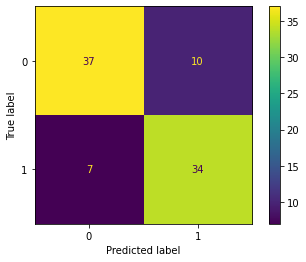

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

rf_model_grid_search_best_params = RandomForestClassifier(random_state = 0, n_estimators = 1000, **gs_grid.best_params_).fit(X_train, y_train)

print("RandomForest Otimizado utilizando GridSearch\n\n")
avaliacao(rf_model_grid_search_best_params, X_test, y_test, X_train, y_train, train_aval = True, plot=True)

Até o momento, os melhores resultados nos scores foram obtidos utilizando o **RandomForest com hiperparâmetrização encontrada usando o plot do GridSearch no dataset com as features medianas**. Houve uma redução significativa no número de Falsos Negativos, com apenas 7FN de 41 pacientes positivos. No entanto, 10 dos 47 pacientes que não precisaram da UTI foram classificados erroneamente. 

Obs.: Note que o `random_state` foi setado para **zero**, tanto como parâmetro do modelo como para o split. Nas outras avaliações, foi tirado a mediana de 50 iterações do modelo com random_states diferentes. Devido ao tempo que os testes tomam, realizei-os em um segundo notebook local, assim como os próximos testes de hiperparâmetros.  

| Random Forest - HYPER GS - Dataset 2 c/ Features Cortadas |  SCORES - MEDIANA  |    STD   |
|:---------------------------------------------------------:|:--------:|:--------:|
|                         ROC (AUC)                         | 0.797353 | 0.036715 |
|                   Sensibilidade - Recall                  | 0.682927 | 0.075739 |
|                       Especificidade                      | 0.735271 | 0.048230 |
|                          F1-score                         | 0.696667 | 0.053468 |
|                          Precisão                         | 0.708922 | 0.049996 |
|                          Acurácia                         | 0.727273 | 0.043840 |



|    Random Forest - HYPER GS - Dataset 2 c/ Features Cortadas    |       SCORES - random_state Definido      |
|:----------------------:|:------------------:|
|        ROC (AUC)       | 0.860923 |
| Sensibilidade - Recall | 0.829268 |
|     Especificidade     | 0.840909 |
|        F1-score        | 0.799999 |
|        Precisão        | 0.772727 |
|        Acurácia        | 0.806818 |

<br>

Utilizei o mesmo notebook local para fazer diversos GridSearchs utilizando mais hiperparâmetros em 3 diferentes datasets:
* df_modelo_mediana
* df_modelo_mediana_corte 
* df_bio

Foram realizados 3 GridSearchs para cada um dos DataFrames, modificando apenas o score de decisão (`average_precision` [RF_GS_AVG_PR], `roc_auc` [RF_GS_ROC_AUC] e `f1`[RF_GS_F1]). Para cada grupo de parâmetros encontrados, utilizei o mesmo procedimento de avaliação anterior: 50 iterações com `random_state` diferentes (tanto no modelo, quanto no split), resumindo os resultados utilizando a mediana dos scores obtidos e o desvio padrão. 

Além disso, adicionei à tabela os resultados do RandomForest nos datasets com parametrização padrão, já calculados nesse notebook. 

<br>
    

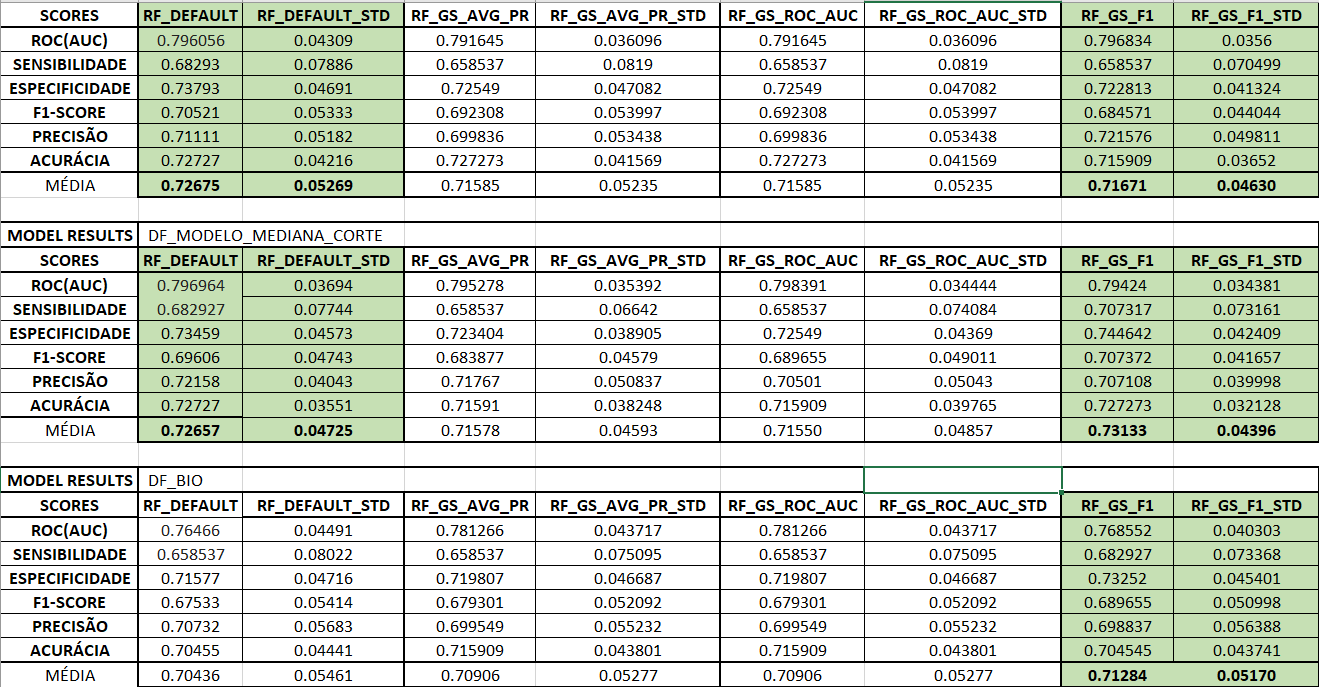

<br>

Os melhores resultados obtidos foram marcados em verde. Além da parametrização padrão, os hiperparâmetros selecionados pelo GridSearch utilizando como métrica o **F1-Score** foram os que se saíram melhor no método de avaliação utilizado,

Abaixo, os resultados dos modelos com o `random_state` definido:

TRAIN SET SCORES
ROC (AUC): 0.9993015946921197
Sensibilidade - Recall: 0.9669421487603306
Especificidade: 0.9726027397260274
F1-score: 0.9831932773109243
Precisão: 1.0
Acurácia: 0.9847908745247148


TEST SET SCORES
ROC (AUC): 0.8666320705760249
Sensibilidade - Recall: 0.8292682926829268
Especificidade: 0.8478260869565217
F1-score: 0.8192771084337348
Precisão: 0.8095238095238095
Acurácia: 0.8295454545454546


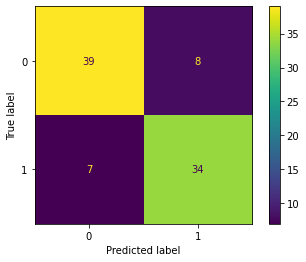

In [ ]:
# Primeiro set de parâmetros - RF_GS_F1 - DF_MODELO_MEDIANA

X = df_modelo_mediana.drop('ICU', axis = 1)
y = df_modelo_mediana['ICU']

best_params = {'bootstrap': True,
 'max_depth': 20,
 'max_features': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_estimators': 1000,
 'random_state': 0}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

rf_gs_mediana_model = RandomForestClassifier(**best_params).fit(X_train, y_train)
avaliacao(rf_gs_mediana_model, X_test, y_test, X_train, y_train, train_aval = True, plot=True)

TRAIN SET SCORES
ROC (AUC): 1.0
Sensibilidade - Recall: 1.0
Especificidade: 1.0
F1-score: 1.0
Precisão: 1.0
Acurácia: 1.0


TEST SET SCORES
ROC (AUC): 0.8515827711468604
Sensibilidade - Recall: 0.8292682926829268
Especificidade: 0.851063829787234
F1-score: 0.8292682926829268
Precisão: 0.8292682926829268
Acurácia: 0.8409090909090909


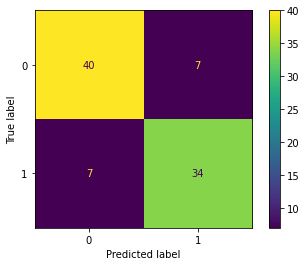

In [ ]:
# Segundo set de parâmetros - RF_GS_F1 - DF_MODELO_MEDIANA_CORTE

X = df_modelo_mediana_corte.drop('ICU', axis = 1)
y = df_modelo_mediana_corte['ICU']

best_params = {'bootstrap': True,
 'max_depth': 20,
 'max_features': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000,
 'random_state': 0}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

rf_gs_corte_model = RandomForestClassifier(**best_params).fit(X_train, y_train)
avaliacao(rf_gs_corte_model, X_test, y_test, X_train, y_train, train_aval = True, plot=True)

TRAIN SET SCORES
ROC (AUC): 1.0
Sensibilidade - Recall: 1.0
Especificidade: 1.0
F1-score: 1.0
Precisão: 1.0
Acurácia: 1.0


TEST SET SCORES
ROC (AUC): 0.8271925272444214
Sensibilidade - Recall: 0.8292682926829268
Especificidade: 0.8372093023255814
F1-score: 0.7906976744186047
Precisão: 0.7555555555555555
Acurácia: 0.7954545454545454


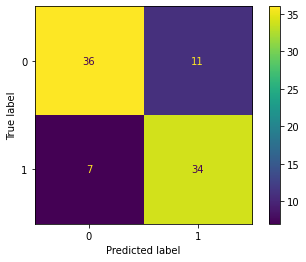

In [ ]:
# Terceiro set de parâmetros - RF_GS_ROC_AUC - DF_BIO

X = df_bio.drop('ICU', axis = 1)
y = df_bio['ICU']

best_params = {'bootstrap': True,
 'max_depth': 20,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1000,
 'random_state': 0}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

rf_gs_bio_model = RandomForestClassifier(**best_params).fit(X_train, y_train)
avaliacao(rf_gs_bio_model, X_test, y_test, X_train, y_train, train_aval = True, plot=True)

Utilizando o RandomForest, os melhores resultados de acordo com as métricas utilizaram o `df_modelo_mediana_corte` e o GridSearch para tunar. No modelo mais otimizado, 14 pacientes de 88 foram classificados de forma errada, sendo 7 **Falso-Negativos** e 7 **Falso-Positivos**. 

Melhor **Score Geral**:

|    RF c/ GS Tunning - df_modelo_mediana_corte    	|  SCORES  	|
|:----------------------:	|:--------:	|
|        ROC (AUC)       	| 0.851582 	|
| Sensibilidade - Recall 	| 0.829268 	|
|     Especificidade     	| 0.851063 	|
|        F1-score        	| 0.829268 	|
|        Precisão        	| 0.829268 	|
|        Acurácia        	| 0.840909 	|


| RF c/ GS Tunning - df_modelo_mediana_corte |  MEDIANA SCORES |   STD   |
|:--------------------------------------------------------:|:-------:|:-------:|
|                         ROC (AUC)                        | 0.79424 | 0.03438 |
|                  Sensibilidade - Recall                  | 0.70732 | 0.07316 |
|                      Especificidade                      | 0.74464 | 0.04241 |
|                         F1-score                         | 0.70737 | 0.04166 |
|                         Precisão                         | 0.70711 | 0.03999 |
|                         Acurácia                         | 0.72727 | 0.00321 |


Apesar de que modelos RandomForest (e outros ensembles de tree decision) podem ser afetados por **overfitting**, o alto número de árvores foi o que causou os scores de treino serem tão elevados e isso não afetou o score de validação.

### eXplainable AI 

Um ponto problemático dos modelos baseados em múltiplas Decision Trees é sua **baixa explicabilidade**. Como um modelo médico, seria interessante demonstrar que features obtiveram maior participação nos resultados dos dados. Utilizarei tanto um gráfico de barras para verificar a **feature_importance**, que acompanha os algoritmos baseados em Random Forest do scikit-learn. Além disso, utilizarei também a **SHAP** para entender ainda melhor.
<br>

Ainda assim, é válido o alerta. **A interpretabilidade do modelo não significa causalidade**. Foi apenas a forma que o algoritmo tomou as decisões. 

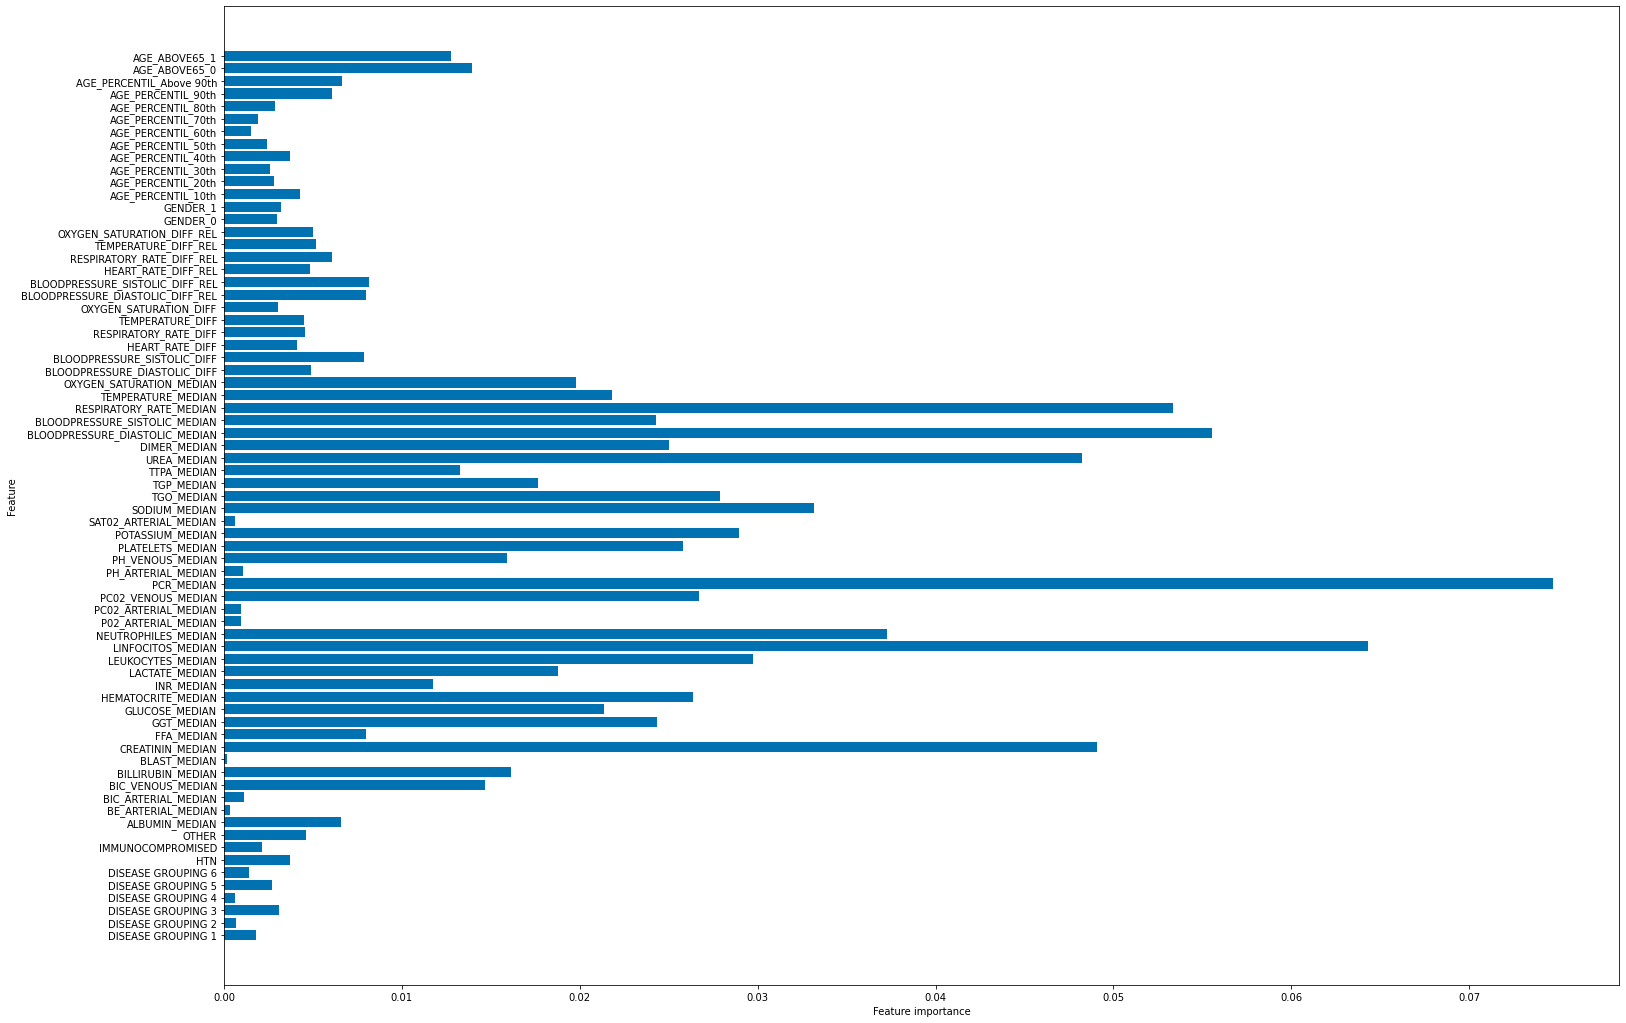

In [ ]:
X = df_modelo_mediana_corte.drop('ICU', axis = 1)
y = df_modelo_mediana_corte['ICU']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify = y)

plot_feature_importance(rf_gs_corte_model)

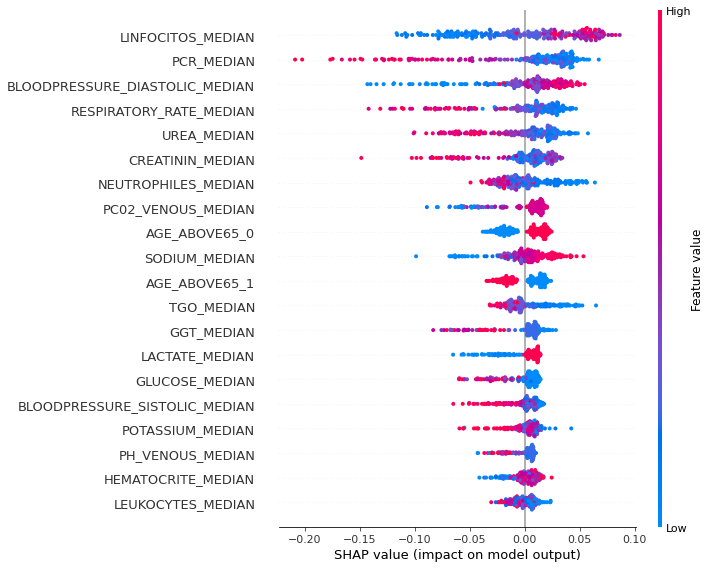

In [ ]:
# Criar o explainer e calcular os valores shap de todo o modelo
explainer = shap.TreeExplainer(rf_gs_corte_model)
shap_values = explainer.shap_values(X_train)

# Plot os valores SHAP para indivíduos que não foram pra UTI
shap.summary_plot(shap_values[0], X_train)

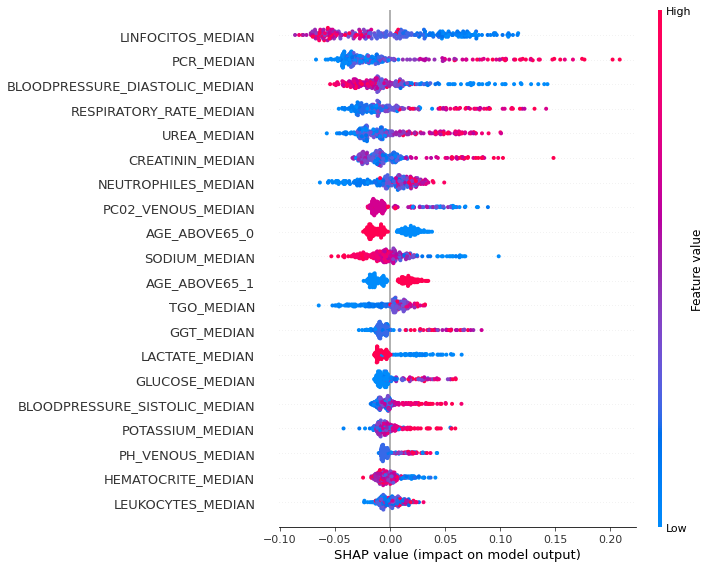

In [ ]:
# Plot os valores SHAP para pacientes que precisaram da UTI
shap.summary_plot(shap_values[1], X_train)

Cada ponto do summary_plot é uma variável do nosso dataset. Sua posição **vertical** indica qual o **nome da feature**, sua **cor** indica o **valor da variável** (em relação com as outras variáveis da mesma feature) e sua posição **horizontal indica** o quanto aquela variável **impactou o modelo**, além do sentido do impacto.

No primeiro plot, estão as features dos pacientes que o modelo preveu que não precisariam da UTI e no segundo, os pacientes que o modelo preveu que seriam admitidos. Vale lembrar também que todos os valores foram pré-escalonados e normalizados, logo um "alto valor na feature RESPIRATORY_RATE_MEDIAN" não tem o mesmo significado direto que uma frequência respiratória alta.

Em pacientes que o modelo classificou que seria necessário a UTI: 
* Altos valores nas features `RESPIRATORY_RATE_MEDIAN`, `PCR_MEDIAN`, `UREA_MEDIAN`, `CREATININ_MEDIAN` tiveram importância alta para a tomada da decisão.
* Valores baixos em features como `LINFOCITOS_MEDIAN`, `OXYGEN_SATURATION_MEDIAN` e `BLOODPRESSURE_DIASTOLIC_MEDIAN` também levaram o modelo à definir a label como 1.
* Assim como havíamos observado na EDA, o modelo também considera o paciente ser maior de 65 anos como uma feature importante.

Já para a previsão que o paciente não entraria na UTI, podemos observar que não houve **nenhuma feature com o valor SHAP muito alto**, diferente da label contrária. A maioria das variáveis, para a previsão `ICU == 0`, possui valor SHAP positivo entre 0 e 0.05. Isso explica o fato do desvio padrão do `recall` ter sido mais alto que o dos outros scores. 

O PermutationImportance, algoritmo que randomiza valores de apenas uma feature no dataset para verificar a diferença que isso causaria nos resultados do modelo e, dessa forma, calcular a importância de dada feature, mostra resultados parecidos ao SHAP.

In [ ]:
perm = PermutationImportance(rf_gs_corte_model, scoring = 'recall', random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(), top=10)

Weight,Feature
0.0878 ± 0.0497,RESPIRATORY_RATE_MEDIAN
0.0488 ± 0.0816,PCR_MEDIAN
0.0488 ± 0.0617,LINFOCITOS_MEDIAN
0.0439 ± 0.0195,CREATININ_MEDIAN
0.0293 ± 0.0365,UREA_MEDIAN
0.0244 ± 0.0000,GLUCOSE_MEDIAN
0.0195 ± 0.0195,AGE_ABOVE65_0
0.0146 ± 0.0239,TGO_MEDIAN
0.0146 ± 0.0497,BLOODPRESSURE_DIASTOLIC_MEDIAN
0.0146 ± 0.0239,AGE_ABOVE65_1


Infelizmente, devida a natureza dos dados e minha leiguisse na área da saúde, fica difícil tirar insights mais profundos sobre o que os valores significam e possíveis relações entre o significado e os resultados do modelo. Entretanto, isso não me impede de mostrar a visualização que algum usuário final - que tenha conhecimentos da área - teria caso procurasse entender melhor os motivos do algoritmo ter previsto a necessidade (ou a falta dela) de um leito na UTI para o paciente. 

In [ ]:
# Procura pelos erros do modelo no set de validação

for i in range(len(X_test)):
    data_for_prediction = X_test.iloc[i]
    data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
    
    prob_arr = rf_gs_corte_model.predict_proba(data_for_prediction_array)
    pred = np.argmax(rf_gs_corte_model.predict_proba(data_for_prediction_array))
    
    if pred != y_test.iloc[i]:
        print(f"\nPrevisão {pred} ||| Probabilidades -  ICU == 0: {prob_arr[0][0]} \t ICU == 1: {prob_arr[0][1]}")
        print(f"Valor V: {y_test.iloc[i]} ||| Index no test_set {i}\n")



Previsão 1 ||| Probabilidades -  ICU == 0: 0.41825793650793675 	 ICU == 1: 0.5817420634920634
Valor V: 0 ||| Index no test_set 1


Previsão 0 ||| Probabilidades -  ICU == 0: 0.5603019841269838 	 ICU == 1: 0.439698015873016
Valor V: 1 ||| Index no test_set 5


Previsão 0 ||| Probabilidades -  ICU == 0: 0.5860565873015869 	 ICU == 1: 0.4139434126984127
Valor V: 1 ||| Index no test_set 9


Previsão 1 ||| Probabilidades -  ICU == 0: 0.26235277777777777 	 ICU == 1: 0.7376472222222222
Valor V: 0 ||| Index no test_set 13


Previsão 1 ||| Probabilidades -  ICU == 0: 0.32106230158730165 	 ICU == 1: 0.6789376984126985
Valor V: 0 ||| Index no test_set 17


Previsão 0 ||| Probabilidades -  ICU == 0: 0.573595238095238 	 ICU == 1: 0.4264047619047617
Valor V: 1 ||| Index no test_set 36


Previsão 0 ||| Probabilidades -  ICU == 0: 0.5880650793650792 	 ICU == 1: 0.4119349206349207
Valor V: 1 ||| Index no test_set 37


Previsão 0 ||| Probabilidades -  ICU == 0: 0.7638007936507933 	 ICU == 1: 0.23619920

In [ ]:
# Observando a tomada de decisão do modelo para um dos erros mais de perto

shap_values = explainer.shap_values(X_test.iloc[79])

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[79])

O modelo preveu, com 76% de probabilidade, que esse paciente não precisaria da UTI. Olhando o gráfico acima podemos verificar os motivos que o modelo levou em consideração para realizar a previsão:
* Paciente na faixa etária do décimo percentil;
* Mediana do sódio, linfócitos e uréia naquela janela de tempo;
* etc.

Para entender ainda melhor o significado de uma feature pro modelo - supondo que o usuário final quisesse visualizar melhor como os valores de `LINFOCITOS_MEDIAN` afetam o modelo (e essa previsão, em específico) com maior precisão - pode-se usar partial plots:

* No Y, a direção que o modelo é afetado
* No X, os valores da feature

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


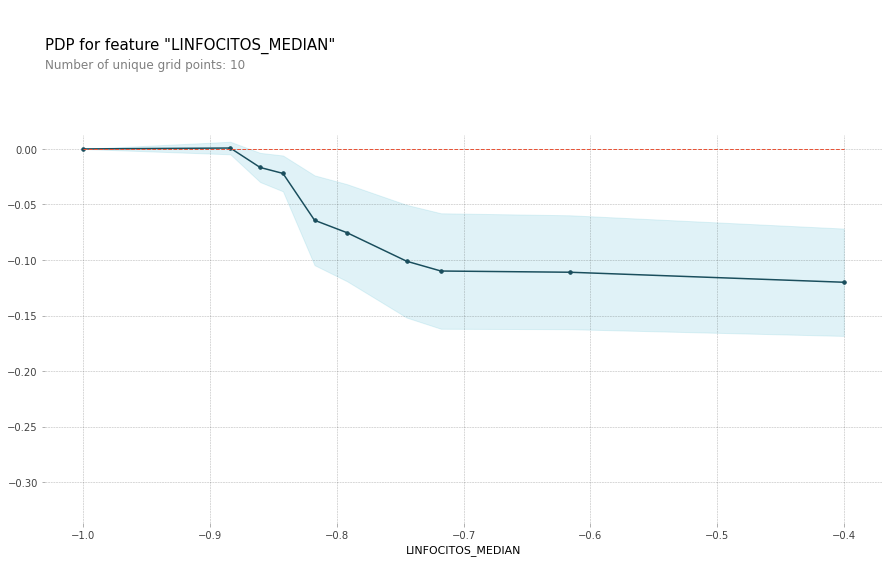

In [ ]:
# Criando o objeto
pdp_linfocitos = pdp.pdp_isolate(model= rf_gs_corte_model, dataset= X_test, model_features= X_test.columns.tolist(), feature='LINFOCITOS_MEDIAN')

# Plotando
pdp.pdp_plot(pdp_linfocitos, 'LINFOCITOS_MEDIAN')
plt.show()

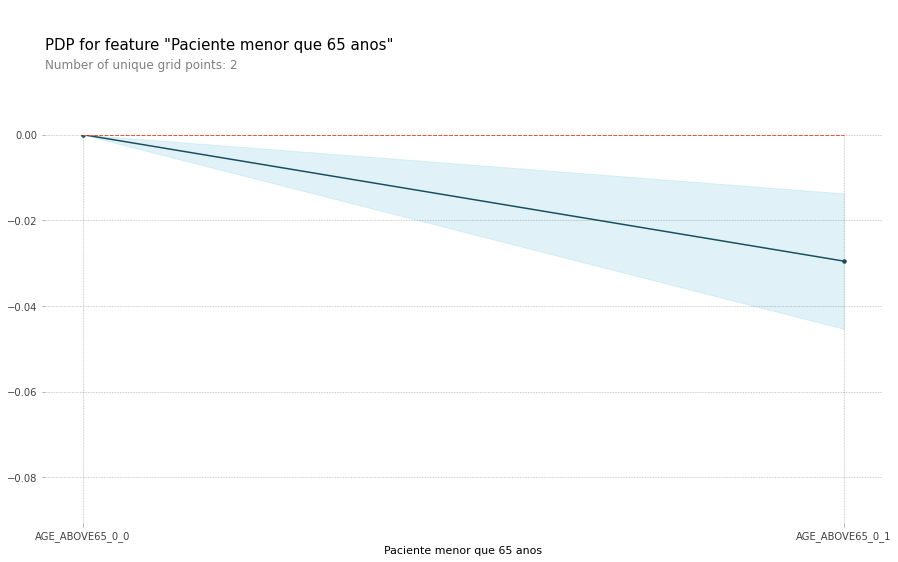

In [ ]:
pdp_age_above65 = pdp.pdp_isolate(model= rf_gs_corte_model, dataset= X_test, model_features= X_test.columns.tolist(), feature='AGE_ABOVE65_0')

pdp.pdp_plot(pdp_age_above65, 'Paciente menor que 65 anos')
plt.show()